# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf
import re

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

## 2) For our current project requirements, we read in batdetect2 outputs to compile # of detections per 30-min intervals

In [6]:
dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/bd2__recover-20230809_UBNA_010.csv')
dets['ref_time'] = pd.to_datetime(dets['input_file'], format="%Y%m%d_%H%M%S", exact=False)
dets_per_file = dets.groupby(['ref_time'])['ref_time'].count()

num_dets = pd.read_csv(f'../output_dir/recover-20230809/Telephone Field/activity__recover-20230809_UBNA_010.csv', index_col=0)
num_dets

num_of_detections  HF2_num_of_detections  \
date_and_time_UTC                                                     
2023-08-02 03:00:00+00:00                  1                      1   
2023-08-02 03:30:00+00:00                  1                      1   
2023-08-02 04:00:00+00:00                  7                      1   
2023-08-02 04:30:00+00:00                 31                      1   
2023-08-02 05:00:00+00:00                 22                      1   
...                                      ...                    ...   
2023-08-09 11:00:00+00:00                  1                      1   
2023-08-09 11:30:00+00:00                  1                      1   
2023-08-09 12:00:00+00:00                 74                      3   
2023-08-09 12:30:00+00:00                  1                      1   
2023-08-09 13:00:00+00:00                  1                      1   

                           HF1_num_of_detections  LF1_num_of_detections  
date_and_time_UTC                                                        
2023-08-02 03:00:00+00:00                      1                      1  
2023-08-02 03:30:00+00:00                      1                      1  
2023-08-02 04:00:00+00:00                      7                      1  
2023-08-02 04:30:00+00:00                     28                      3  
2023-08-02 05:00:00+00:00                      1                     22  
...                                          ...                    ...  
2023-08-09 11:00:00+00:00                      1                      1  
2023-08-09 11:30:00+00:00                      1                      1  
2023-08-09 12:00:00+00:00                     71                      1  
2023-08-09 12:30:00+00:00                      1                      1  
2023-08-09 13:00:00+00:00                      1                      1  

[168 rows x 4 columns]

## 3) These results are saved as dataframes to allow easy manipulation

In [7]:
activity_datetimes = pd.to_datetime(num_dets.index.values)
raw_dates = activity_datetimes.strftime("%m/%d/%y")
raw_times = activity_datetimes.strftime("%H:%M")

col_name = f"num_of_detections"
data = list(zip(raw_dates, raw_times, num_dets[col_name]))
activity = pd.DataFrame(data, columns=["Date (UTC)", "Time (UTC)", col_name])
activity_df = activity.pivot(index="Time (UTC)", columns="Date (UTC)", values=col_name)
activity_df

Date (UTC)  08/02/23  08/03/23  08/04/23  08/05/23  08/06/23  08/07/23  \
Time (UTC)                                                               
03:00              1         1         1         1         1         1   
03:30              1         1         1         1         7         1   
04:00              7       120        29        24        29        23   
04:30             31       185        29         4        43       148   
05:00             22        25        13         5         2         2   
05:30             60         1         1         1         1         2   
06:00              3         1        72         1         1        19   
06:30             62        65         1        10         2         2   
07:00             95        78         1         1        35         1   
07:30             41         1         2        14        32        77   
08:00             26         4        46         1       266        37   
08:30             20        16         1         1         2        53   
09:00             65        87         1         2       114        82   
09:30              1         7        13         1         9       259   
10:00              1        21         1         1        30         1   
10:30             40         1         1         3         1       159   
11:00              1        40         1        30         3       109   
11:30             12         4        26         1         2         1   
12:00              1         1         1         6         1         1   
12:30              3         1         1         1         1         1   
13:00              1         1         1         1         2         1   

Date (UTC)  08/08/23  08/09/23  
Time (UTC)                      
03:00              1         1  
03:30              1         1  
04:00            422       269  
04:30              9         1  
05:00              1        23  
05:30              1        10  
06:00              8        12  
06:30             10         1  
07:00              9       136  
07:30              1        44  
08:00             19        39  
08:30             30         1  
09:00            125        23  
09:30             52         1  
10:00            160         8  
10:30            351         1  
11:00             35         1  
11:30             15         1  
12:00             13        74  
12:30              1         1  
13:00              1         1

## 4) A later addition to this repository was `src/file_dealer.py` which assembles a comprehensive summary of all collected records from a given hard drive

In [8]:
cfg = dict()
cfg["input_dir"] = f'{Path.home()}/Documents/Research/Symposium/Recordings'
cfg["output_dir"] = Path("../output_dir")
cfg['time'] = '07:30'
cfg['date'] = '08'
cfg["month"] = 'July'
cfg['year'] = '2022'

In [9]:
(dt.datetime.strptime(cfg['time'], '%H:%M')).time()

datetime.time(7, 30)

In [10]:
cur_data_records = pd.read_csv(f'../output_dir/ubna_data_03_collected_audio_records.csv', dtype=str, index_col=0)
cur_data_records["datetime_UTC"] = pd.DatetimeIndex(cur_data_records["datetime_UTC"])
cur_data_records.set_index("datetime_UTC", inplace=True)

In [11]:
cur_data_records.loc[(cur_data_records.index>=dt.datetime(2023, 9, 20))&(cur_data_records['sd_card_num']=='007')]

site_name    recover_folder audiomoth_num sd_card_num  \
datetime_UTC                                                                
2023-09-21 00:00:00   Foliage  recover-20230927             G         007   
2023-09-21 00:30:00   Foliage  recover-20230927             G         007   
2023-09-21 01:00:00   Foliage  recover-20230927             G         007   
2023-09-21 01:30:00   Foliage  recover-20230927             G         007   
2023-09-21 02:00:00   Foliage  recover-20230927             G         007   
...                       ...               ...           ...         ...   
2023-12-28 18:00:00   Foliage  recover-20231228             G         007   
2023-12-28 18:30:00   Foliage  recover-20231228             G         007   
2023-12-28 19:00:00   Foliage  recover-20231228             G         007   
2023-12-28 19:30:00   Foliage  recover-20231228             G         007   
2023-12-28 20:00:00   Foliage  recover-20231228             G         007   

                                                             file_path  \
datetime_UTC                                                             
2023-09-21 00:00:00  /mnt/ubna_data_03/recover-20230927/UBNA_007/20...   
2023-09-21 00:30:00  /mnt/ubna_data_03/recover-20230927/UBNA_007/20...   
2023-09-21 01:00:00  /mnt/ubna_data_03/recover-20230927/UBNA_007/20...   
2023-09-21 01:30:00  /mnt/ubna_data_03/recover-20230927/UBNA_007/20...   
2023-09-21 02:00:00  /mnt/ubna_data_03/recover-20230927/UBNA_007/20...   
...                                                                ...   
2023-12-28 18:00:00  /mnt/ubna_data_03/recover-20231228/UBNA_007/20...   
2023-12-28 18:30:00  /mnt/ubna_data_03/recover-20231228/UBNA_007/20...   
2023-12-28 19:00:00  /mnt/ubna_data_03/recover-20231228/UBNA_007/20...   
2023-12-28 19:30:00  /mnt/ubna_data_03/recover-20231228/UBNA_007/20...   
2023-12-28 20:00:00  /mnt/ubna_data_03/recover-20231228/UBNA_007/20...   

                                                         file_metadata  \
datetime_UTC                                                             
2023-09-21 00:00:00  Recorded at 00:00:00 21/09/2023 (UTC) by Audio...   
2023-09-21 00:30:00  Recorded at 00:30:00 21/09/2023 (UTC) by Audio...   
2023-09-21 01:00:00  Recorded at 01:00:00 21/09/2023 (UTC) by Audio...   
2023-09-21 01:30:00  Recorded at 01:30:00 21/09/2023 (UTC) by Audio...   
2023-09-21 02:00:00  Recorded at 02:00:00 21/09/2023 (UTC) by Audio...   
...                                                                ...   
2023-12-28 18:00:00  Recorded at 18:00:00 28/12/2023 (UTC) by Audio...   
2023-12-28 18:30:00  Recorded at 18:30:00 28/12/2023 (UTC) by Audio...   
2023-12-28 19:00:00  Recorded at 19:00:00 28/12/2023 (UTC) by Audio...   
2023-12-28 19:30:00  Recorded at 19:30:00 28/12/2023 (UTC) by Audio...   
2023-12-28 20:00:00  Recorded at 20:00:00 28/12/2023 (UTC) by Audio...   

                              file_status audiomoth_temperature  \
datetime_UTC                                                      
2023-09-21 00:00:00  Usable for detection                 17.1C   
2023-09-21 00:30:00  Usable for detection                 19.6C   
2023-09-21 01:00:00  Usable for detection                 21.2C   
2023-09-21 01:30:00  Usable for detection                 19.1C   
2023-09-21 02:00:00  Usable for detection                 18.0C   
...                                   ...                   ...   
2023-12-28 18:00:00  Usable for detection                  8.8C   
2023-12-28 18:30:00  Usable for detection                  9.4C   
2023-12-28 19:00:00  Usable for detection                 10.1C   
2023-12-28 19:30:00  Usable for detection                 10.9C   
2023-12-28 20:00:00  Usable for detection                 10.7C   

                    audiomoth_battery sample_rate         audiomoth_artist_ID  \
datetime_UTC                                                                    
2023-09-21 00:00:00              4.2V      192000  AudioMo

### We can gather all the 'good' files using this Dataframe instead of having to check for good files during detection.

In [12]:
hard_drive_df = dd.read_csv(f'../output_dir/ubna_data_*_collected_audio_records.csv', dtype=str).compute()
if 'Unnamed: 0' in hard_drive_df.columns:
    hard_drive_df.drop(columns='Unnamed: 0', inplace=True)
hard_drive_df["Datetime UTC"] = pd.DatetimeIndex(hard_drive_df["Datetime UTC"])
hard_drive_df.set_index("Datetime UTC", inplace=True)

site_name = 'Foliage'
data_params = dict()
data_params['site'] = site_name

site_name_cond = hard_drive_df["Site name"] == site_name

file_year_cond = hard_drive_df.index.year == (dt.datetime.strptime(cfg['year'], '%Y')).year
file_month_cond = hard_drive_df.index.month == (dt.datetime.strptime(cfg['month'], '%B')).month
file_day_cond = hard_drive_df.index.day == (dt.datetime.strptime(cfg['date'], '%d')).day
file_time_cond = hard_drive_df.index.time == (dt.datetime.strptime(cfg['time'], '%H:%M')).time()

minute_cond = np.logical_or((hard_drive_df.index).minute == 30, (hard_drive_df.index).minute == 0)
datetime_cond = np.logical_and((hard_drive_df.index).second == 0, minute_cond)
file_error_cond = np.logical_and((hard_drive_df["File duration"]!='File has no comment due to error!'), (hard_drive_df["File duration"]!='File has no Audiomoth-related comment'))
all_errors_cond = np.logical_and((hard_drive_df["File duration"]!='Is empty!'), file_error_cond)
file_date_cond = np.logical_and(np.logical_and(file_year_cond, file_month_cond), np.logical_and(file_time_cond, file_day_cond))

filtered_location_df = hard_drive_df.loc[site_name_cond&datetime_cond&file_date_cond&all_errors_cond].sort_index()
filtered_location_nightly_df = filtered_location_df.between_time('03:00', '13:30', inclusive="left")

data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
print(f"Will save csv file to {data_params['output_dir']}")

data_params['ref_audio_files'] = filtered_location_nightly_df["File path"].apply(lambda x : Path(x)).values
file_status_cond = filtered_location_nightly_df["File status"] == "Usable for detection"
file_duration_cond = np.isclose(filtered_location_nightly_df["File duration"].astype('float'), 1795)
good_deploy_session_df = filtered_location_nightly_df.loc[file_status_cond&file_duration_cond]
data_params['good_audio_files'] = good_deploy_session_df["File path"].apply(lambda x : Path(x)).values
data_params['recover_folder'] = good_deploy_session_df["Recover folder"].values
data_params['audiomoth_folder'] = good_deploy_session_df["SD card #"].values

if list(data_params['good_audio_files']) == list(data_params['ref_audio_files']):
    print("All files from deployment session good!")
else:
    print("Error files exist!")

data_params['good_audio_files']

Will save csv file to ../output_dir/Foliage
All files from deployment session good!


array([PosixPath('/mnt/ubna_data_01/recover-20220709_unit3/20220708_073000.WAV')],
      dtype=object)

##### **Checking the difference between glob.glob() and Path.glob()**

In [13]:
glob.glob(f"{cfg['input_dir']}/**/*.WAV", recursive=True)[1]

'/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_070000.WAV'

In [14]:
path_glob = Path(cfg['input_dir']).glob(pattern='**/*.WAV')
files = list(path_glob)
files[1]

PosixPath('/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_070000.WAV')

##### **Printing out the outputs of exiftool.get_metadata()**

In [15]:
with exiftool.ExifToolHelper() as et:
    print(et.get_metadata(files[0]))

[{'SourceFile': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009/20221017_083000.WAV', 'ExifTool:ExifToolVersion': 12.63, 'File:FileName': '20221017_083000.WAV', 'File:Directory': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20221017/UBNA_009', 'File:FileSize': 689280488, 'File:FileModifyDate': '2023:05:03 22:22:13-07:00', 'File:FileAccessDate': '2023:05:03 22:22:14-07:00', 'File:FileInodeChangeDate': '2023:11:17 11:55:29-08:00', 'File:FilePermissions': 100644, 'File:FileType': 'WAV', 'File:FileTypeExtension': 'WAV', 'File:MIMEType': 'audio/x-wav', 'RIFF:Encoding': 1, 'RIFF:NumChannels': 1, 'RIFF:SampleRate': 192000, 'RIFF:AvgBytesPerSec': 384000, 'RIFF:BitsPerSample': 16, 'RIFF:Comment': 'Recorded at 08:30:00 17/10/2022 (UTC) by AudioMoth 24F319055FDF2F5B at medium gain while battery was 3.8V and temperature was 13.6C.', 'RIFF:Artist': 'AudioMoth 24F319055FDF2F5B', 'Composite:Duration': 1795.00127083333}]


## 4) Develop any of the main functions below:

### a) Using `dask.dataframe` to concatenate all generated detections into 1 large `pandas.dataframe`.

In [16]:
new_df = dd.read_csv(f"../output_dir/recover-2023*/Telephone Field/bd2__*.csv").compute()
new_df

start_time  end_time  low_freq  high_freq  detection_confidence  \
0      162.4855  162.4921   46953.0    56985.0                 0.632   
1      164.9085  164.9138   44375.0    52060.0                 0.528   
2      168.0525  168.0585   46953.0    57225.0                 0.598   
3      168.9195  168.9253   47812.0    58804.0                 0.581   
4      169.3145  169.3201   46953.0    57417.0                 0.629   
..          ...       ...       ...        ...                   ...   
106    276.9115  276.9189   27187.0    36352.0                   NaN   
107    277.1235  277.1313   27187.0    35025.0                   NaN   
108    277.3455  277.3543   27187.0    40231.0                   NaN   
109    103.4325  103.4574   17734.0    20337.0                   NaN   
110    125.4525  125.4654   11718.0    20319.0                   NaN   

            event                                         input_file  \
0    Echolocation                                20230531_043000.WAV   
1    Echolocation                                20230531_043000.WAV   
2    Echolocation                                20230531_043000.WAV   
3    Echolocation                                20230531_043000.WAV   
4    Echolocation                                20230531_043000.WAV   
..            ...                                                ...   
106  Echolocation  /mnt/ubna_data_03/recover-20231228/UBNA_018/20...   
107  Echolocation  /mnt/ubna_data_03/recover-20231228/UBNA_018/20...   
108  Echolocation  /mnt/ubna_data_03/recover-20231228/UBNA_018/20...   
109  Echolocation  /mnt/ubna_data_03/recover-20231228/UBNA_018/20...   
110  Echolocation  /mnt/ubna_data_03/recover-20231228/UBNA_018/20...   

                   class  class_prob  det_prob  individual    Recover Folder  \
0                    NaN         NaN       NaN         NaN               NaN   
1                    NaN         NaN       NaN         NaN               NaN   
2                    NaN         NaN       NaN         NaN               NaN   
3                    NaN         NaN       NaN         NaN               NaN   
4                    NaN         NaN       NaN         NaN               NaN   
..                   ...         ...       ...         ...               ...   
106  Eptesicus serotinus       0.313     0.653        -1.0  recover-20231228   
107    Nyctalus leisleri       0.318     0.653        -1.0  recover-20231228   
108    Nyctalus leisleri       0.499     0.705        -1.0  recover-20231228   
109     Nyctalus noctula       0.419     0.542        -1.0  recover-20231228   
110    Nyctalus leisleri       0.300     0.568        -1.0  recover-20231228   

      SD Card                          Site name  
0         NaN                                NaN  
1         NaN                                NaN  
2         NaN                                NaN  
3         NaN                                NaN  
4         NaN                                NaN  
..        ...                                ...  
106  UBNA_018  (Site not found in Field Records)  
107  UBNA_018  (Site not found in Field Records)  
108  UBNA_018  (Site not found in Field Records)  
109  UBNA_018  (Site not found in Field Records)  
110  UBNA_018  (Site not found in Field Records)  

[1201821 rows x 14 columns]

### b) This concatenation is used to plot a location summary of activity
### The below plots generate the cumulative plots found in `output_dir/cumulative_plots` 

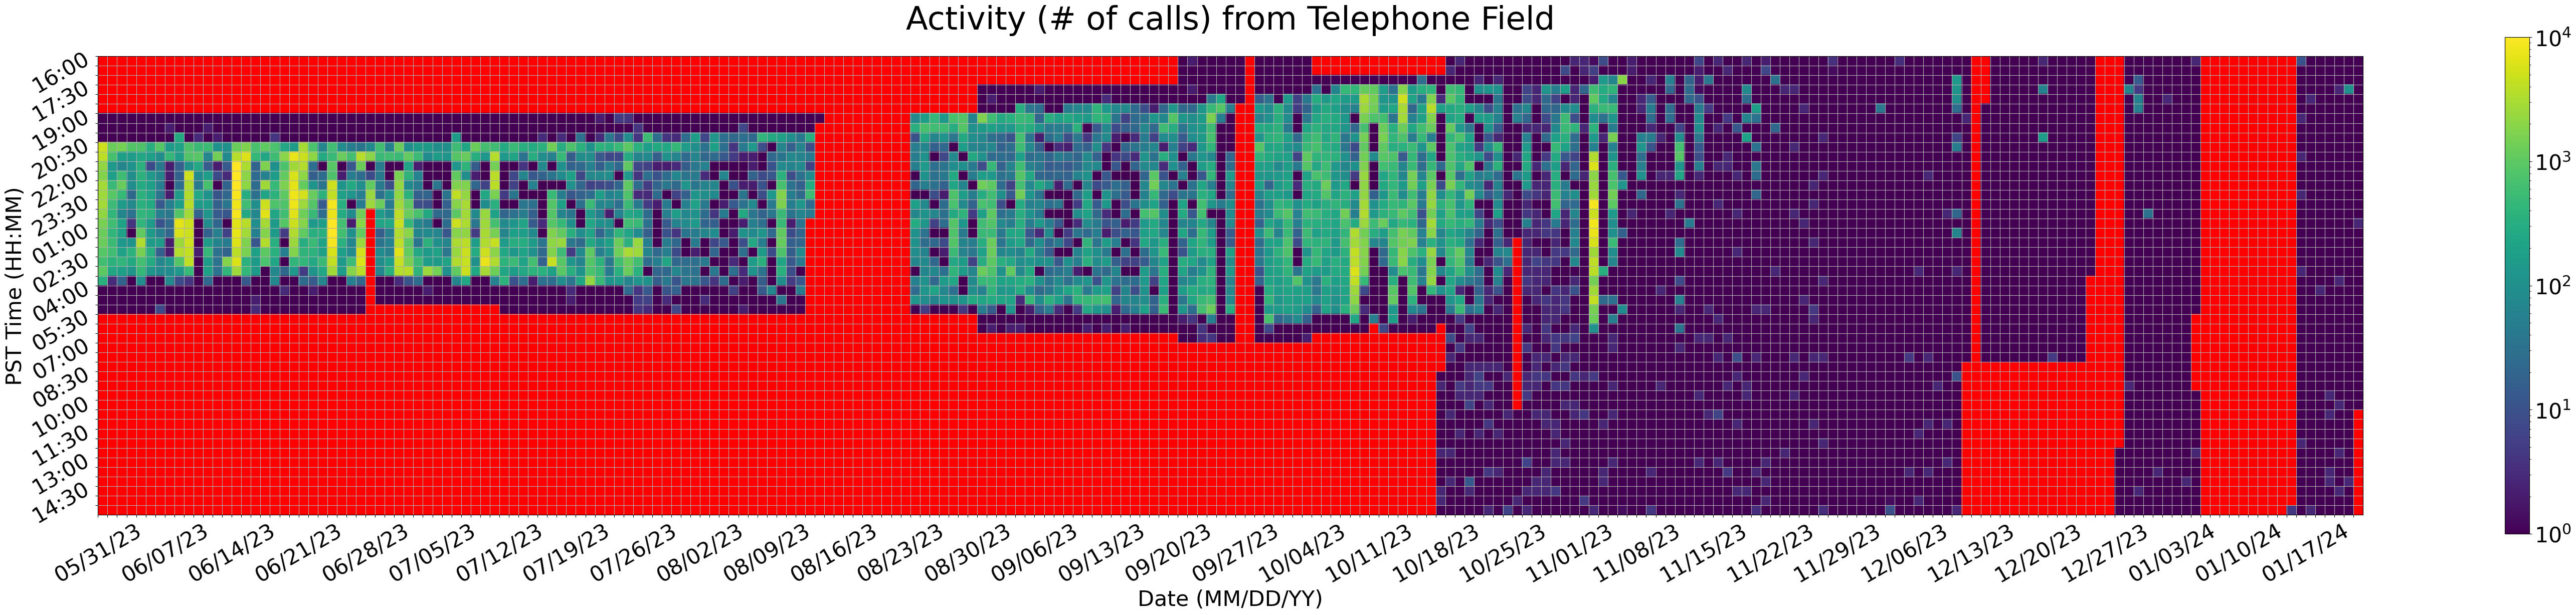

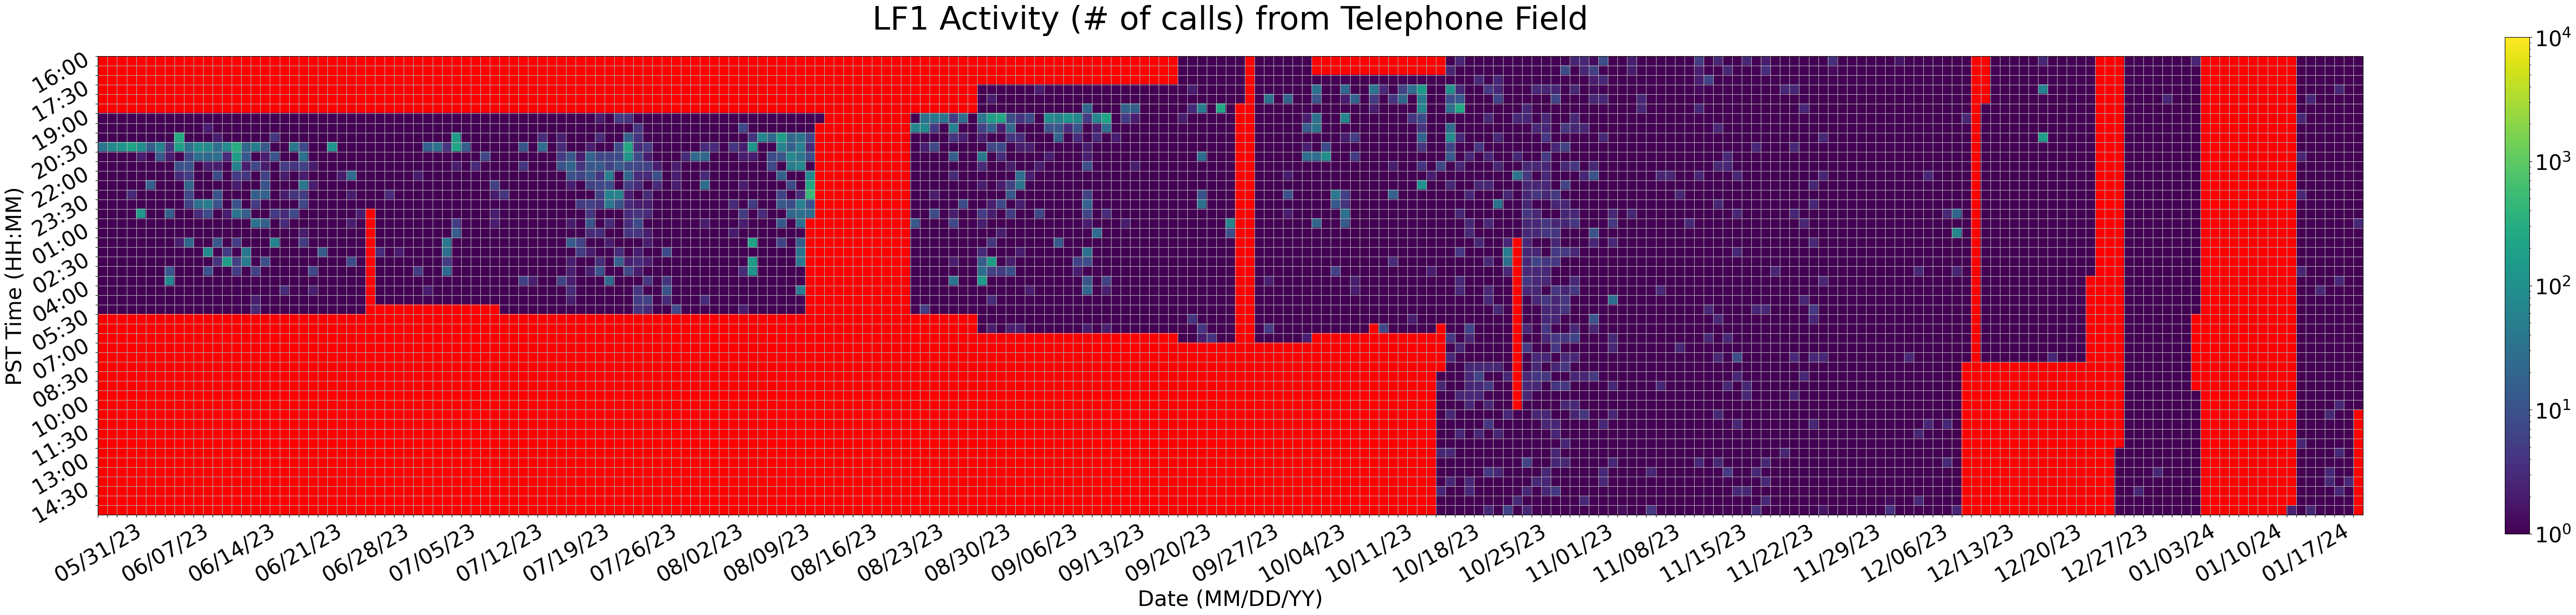

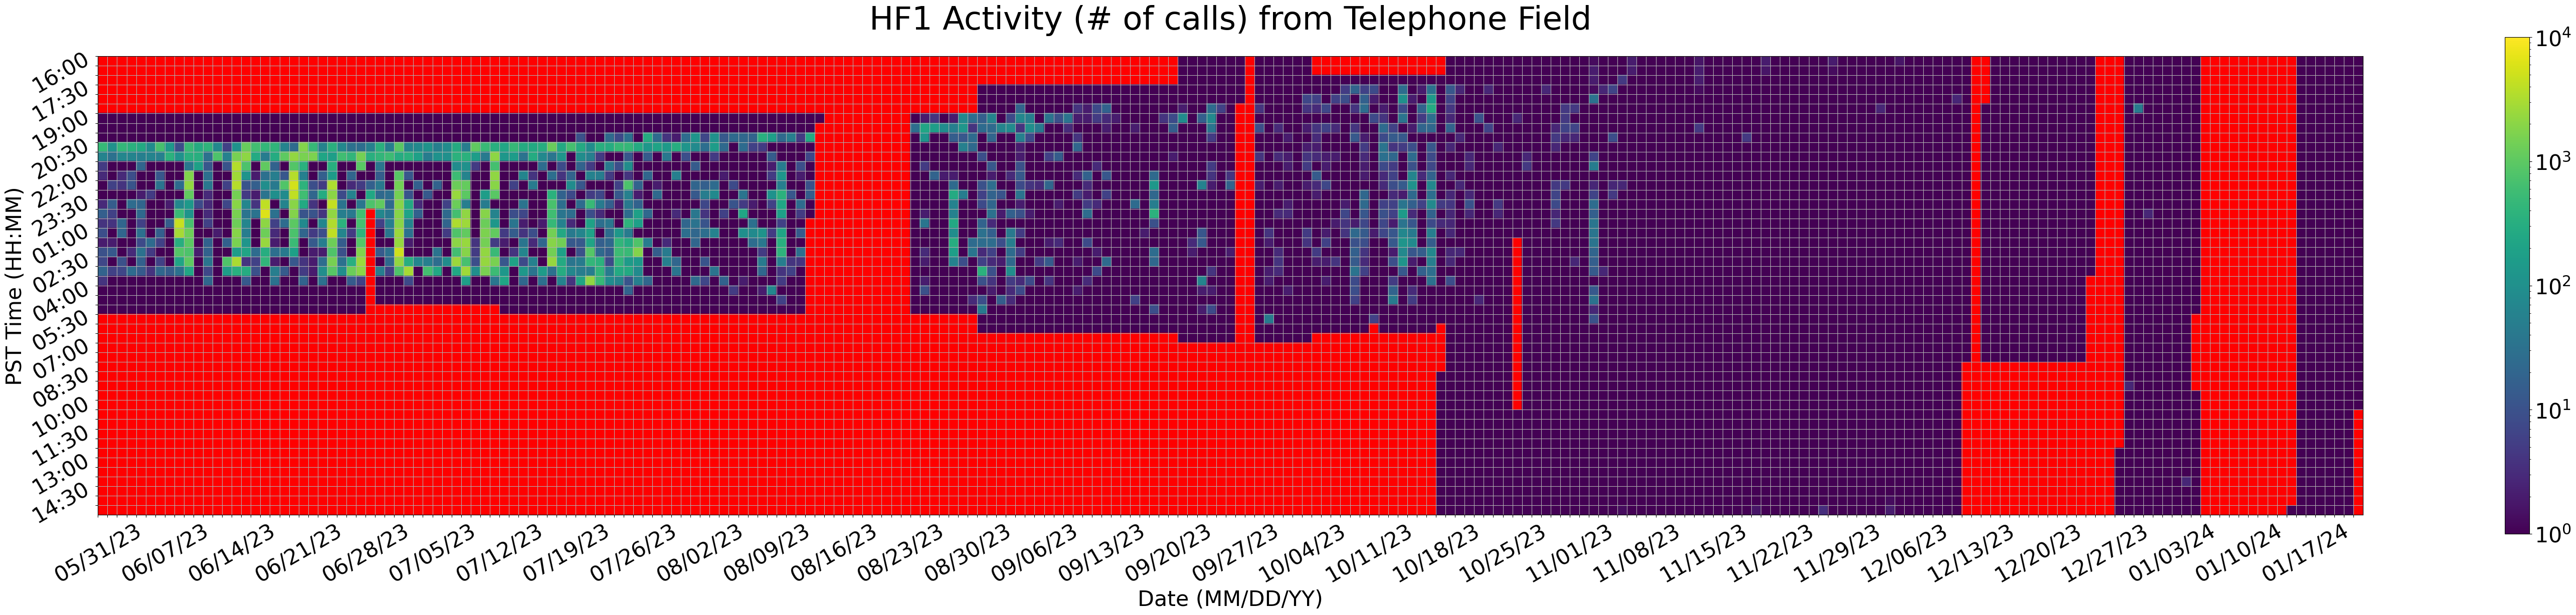

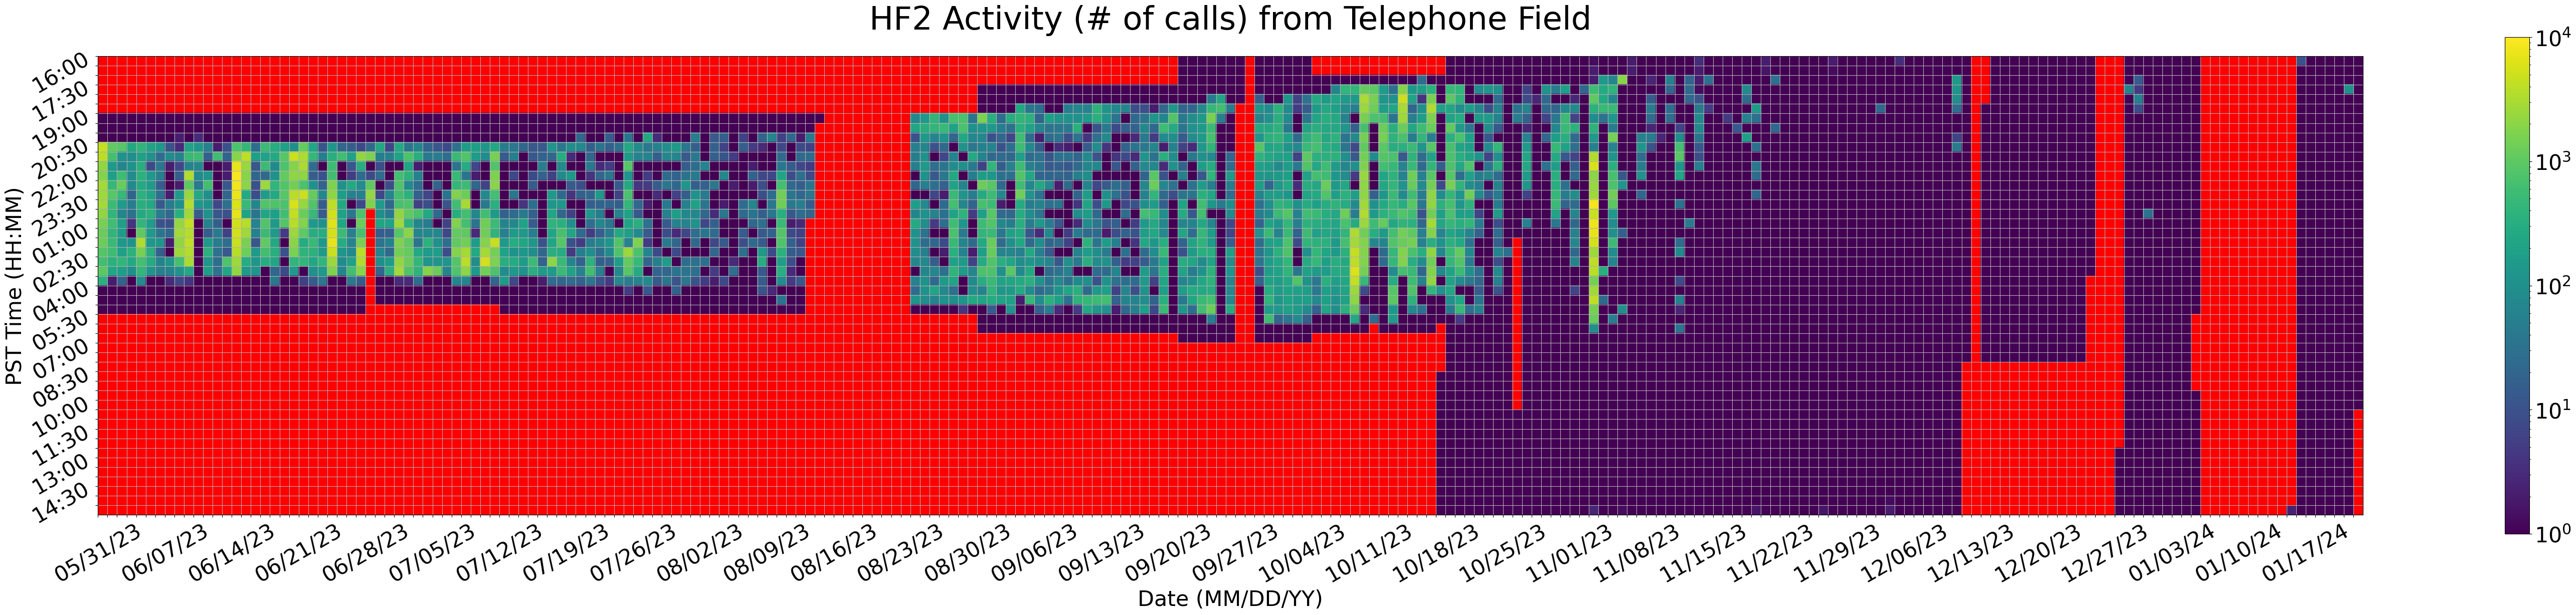

In [ ]:
site = "Telephone Field"
cfg = dict()
cfg["site"] = site
cfg["recording_start"] = '00:00'
cfg["recording_end"] = '23:59'
cfg['resample_tag'] = "30T"
cfg['show_PST'] = True

for group in batdetect2_pipeline.FREQ_GROUPS[cfg["site"]].keys():
    activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, group)
    batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, group)

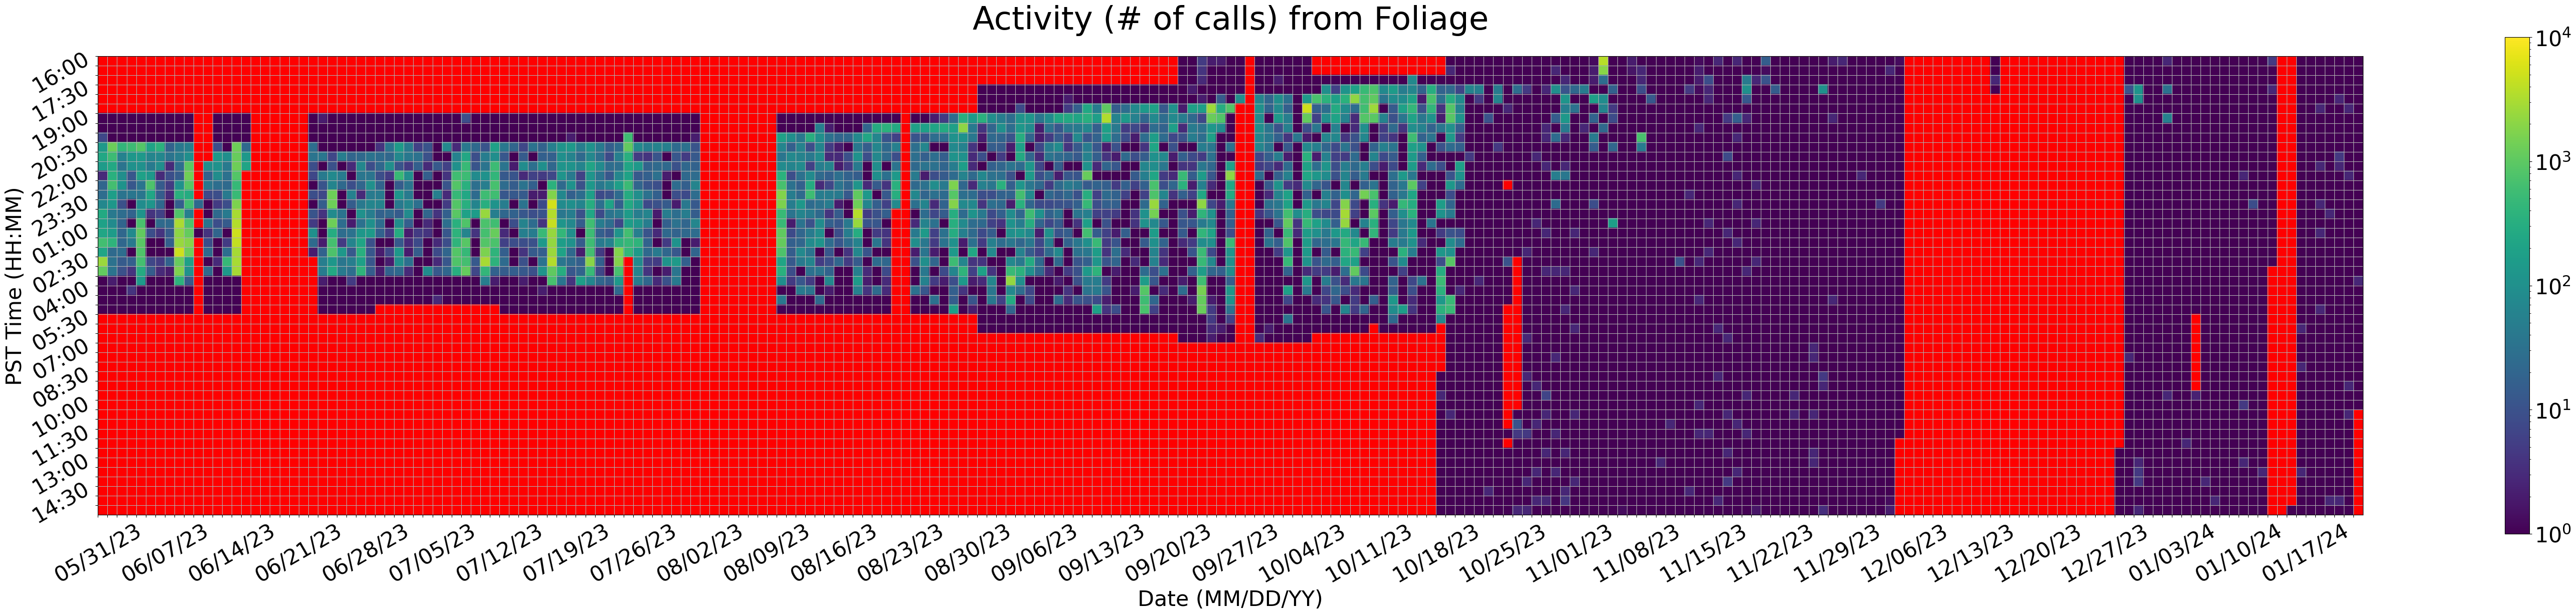

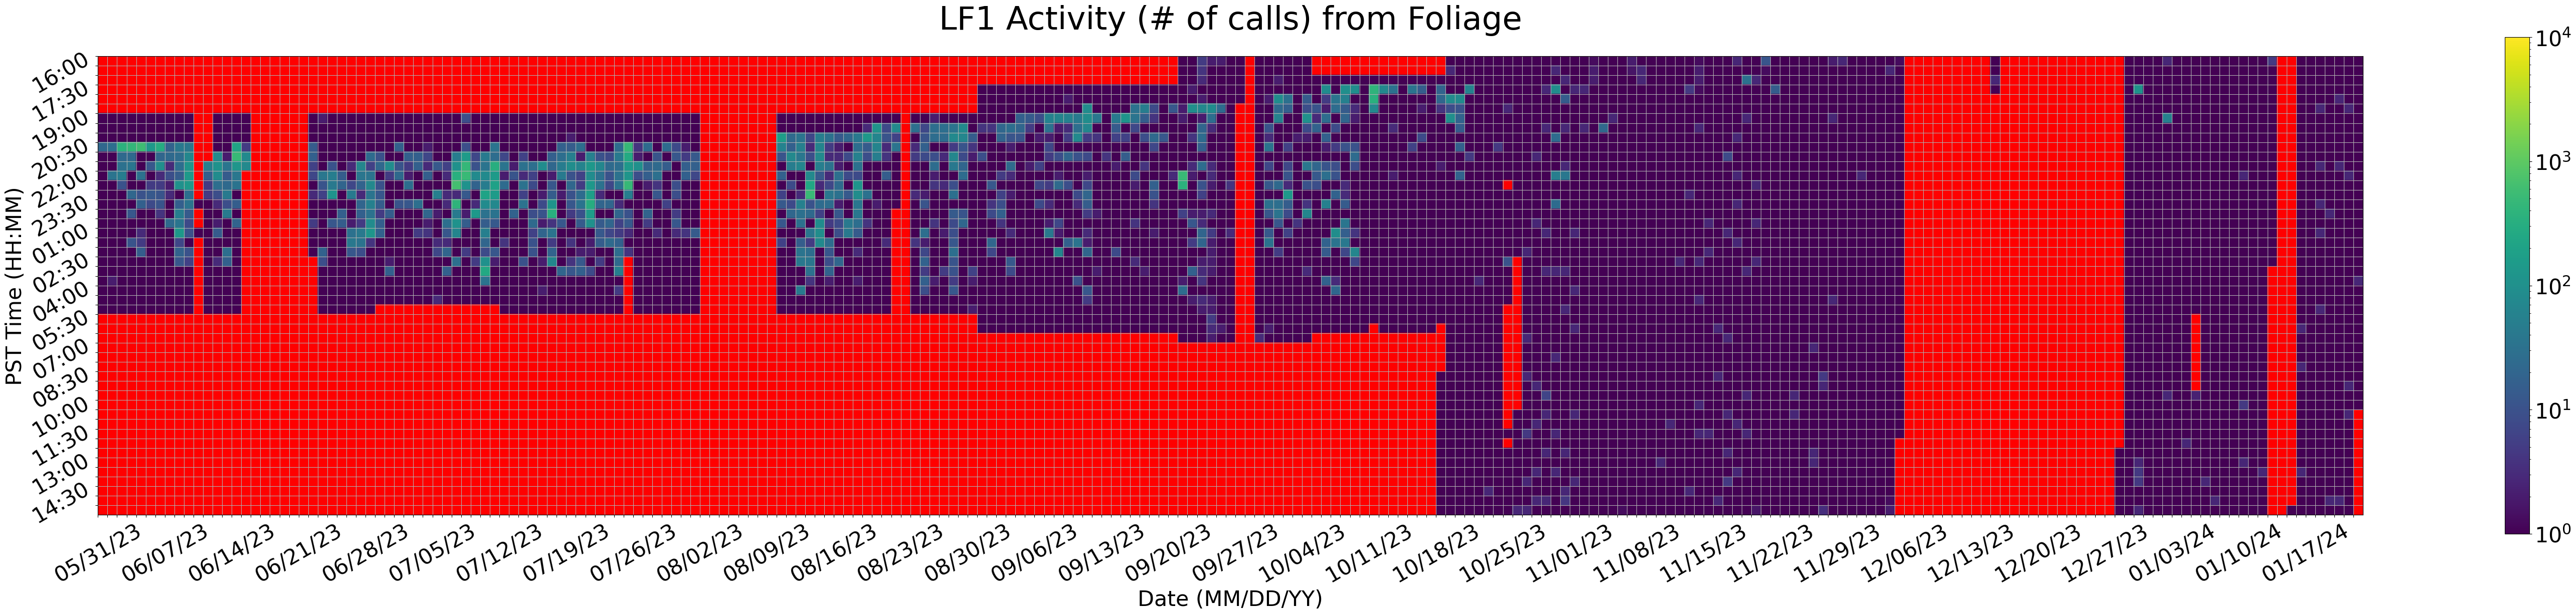

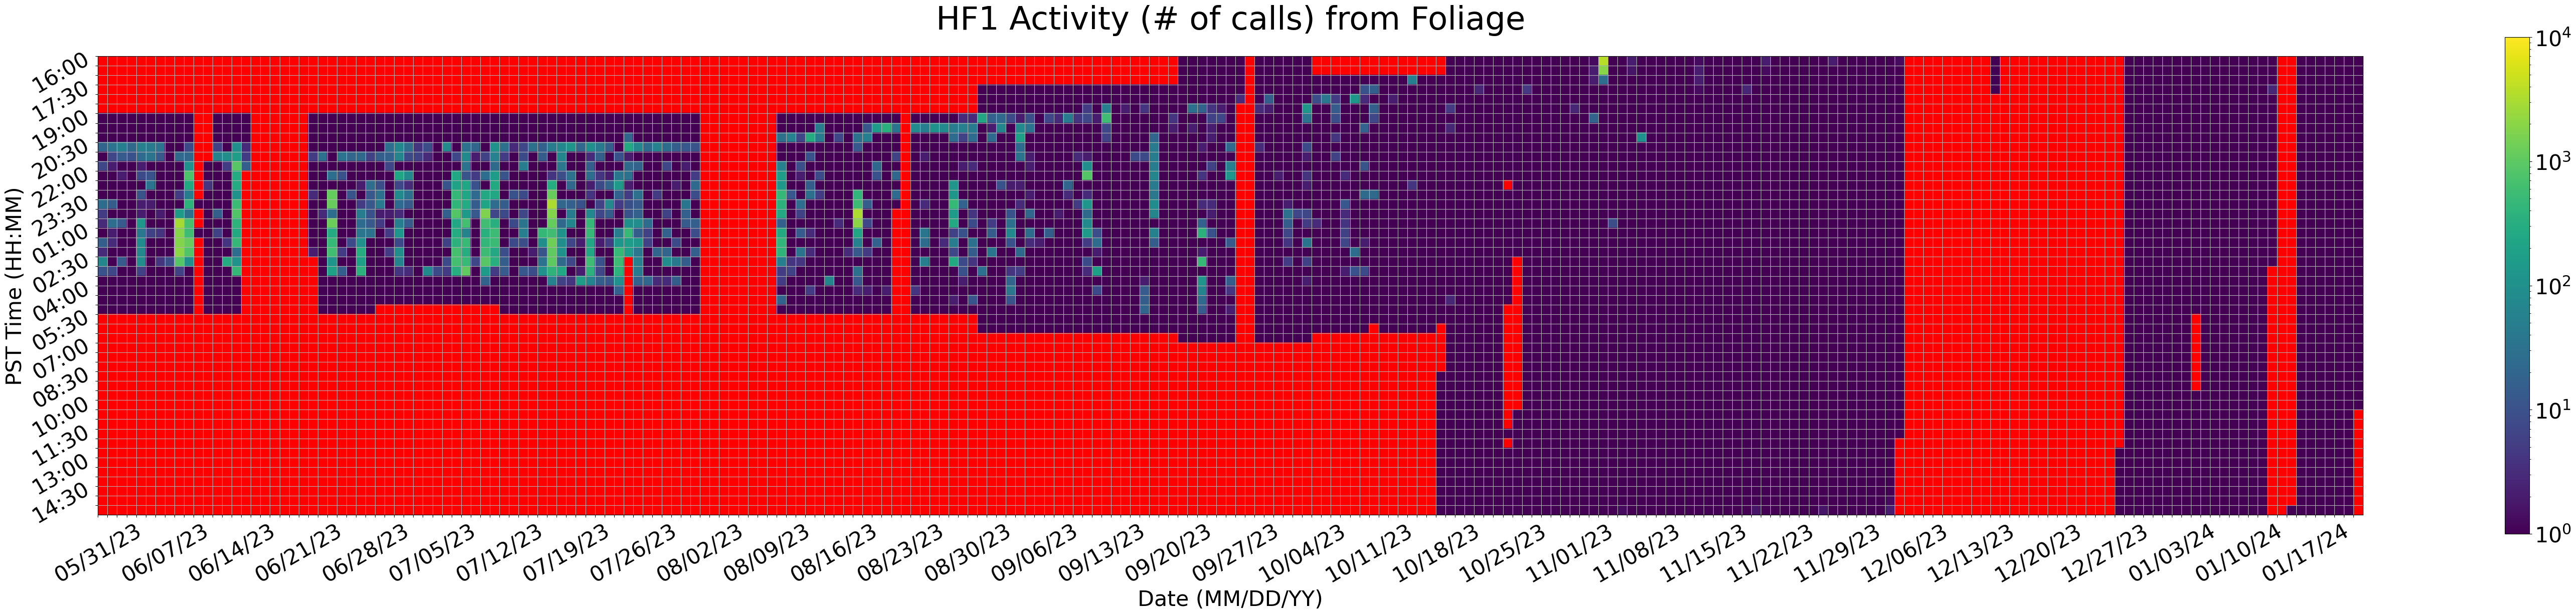

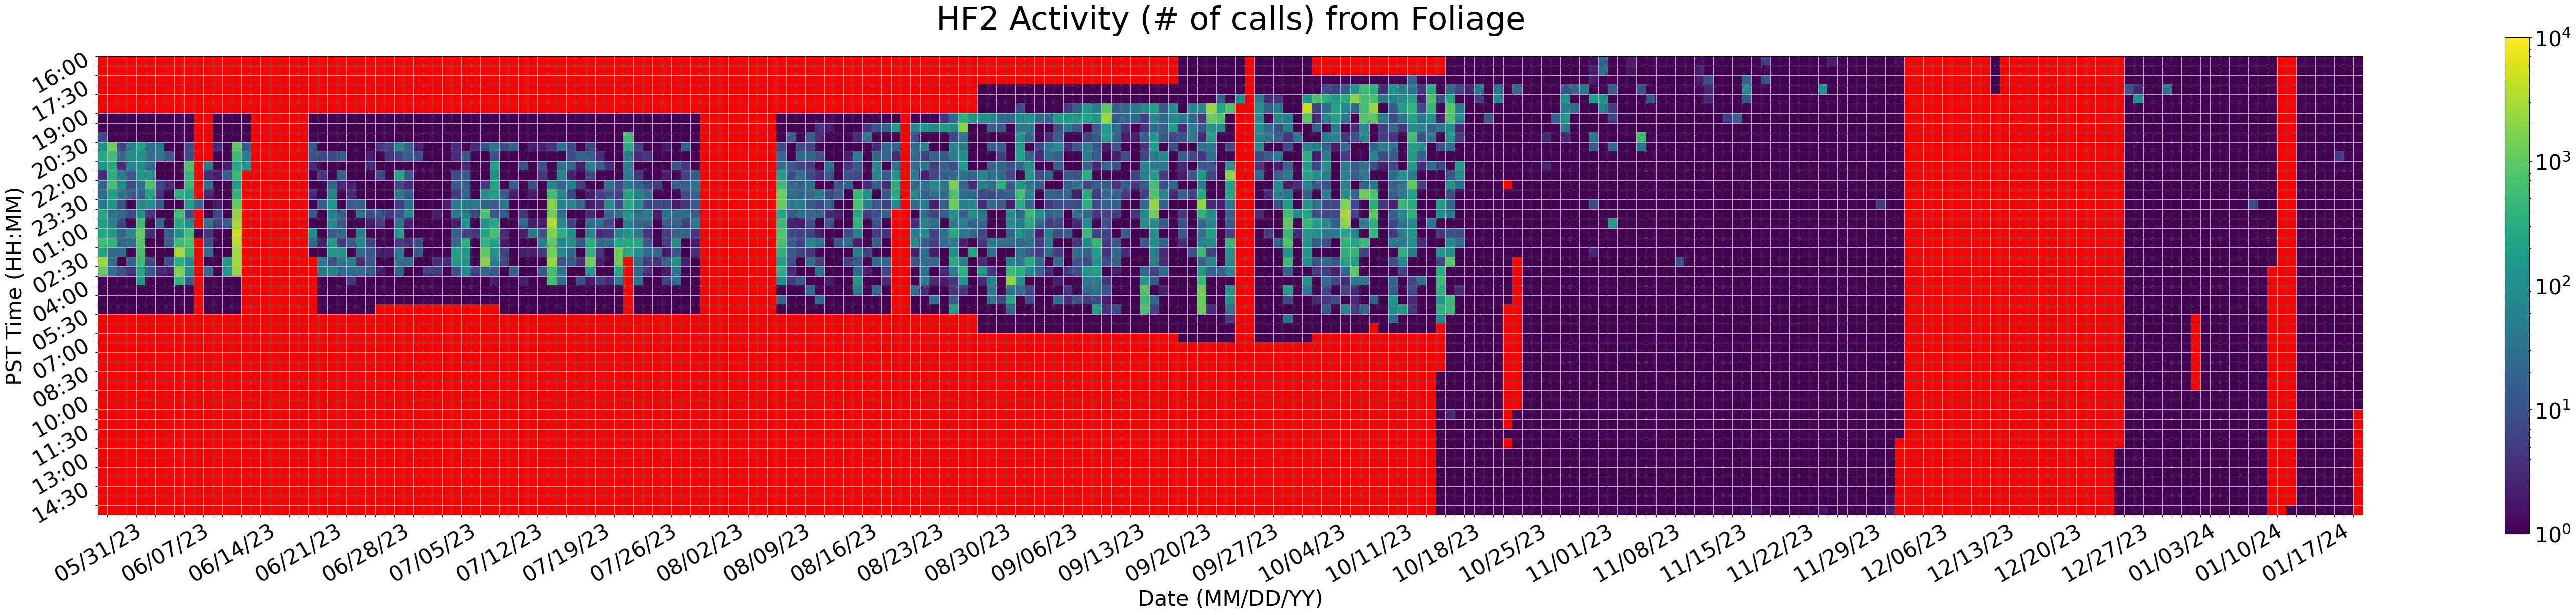

In [ ]:
site = "Foliage"
cfg = dict()
cfg["site"] = site
cfg["recording_start"] = '00:00'
cfg["recording_end"] = '23:59'
cfg['resample_tag'] = "30T"
cfg['show_PST'] = True

for group in batdetect2_pipeline.FREQ_GROUPS[cfg["site"]].keys():
    activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, group)
    batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, group)

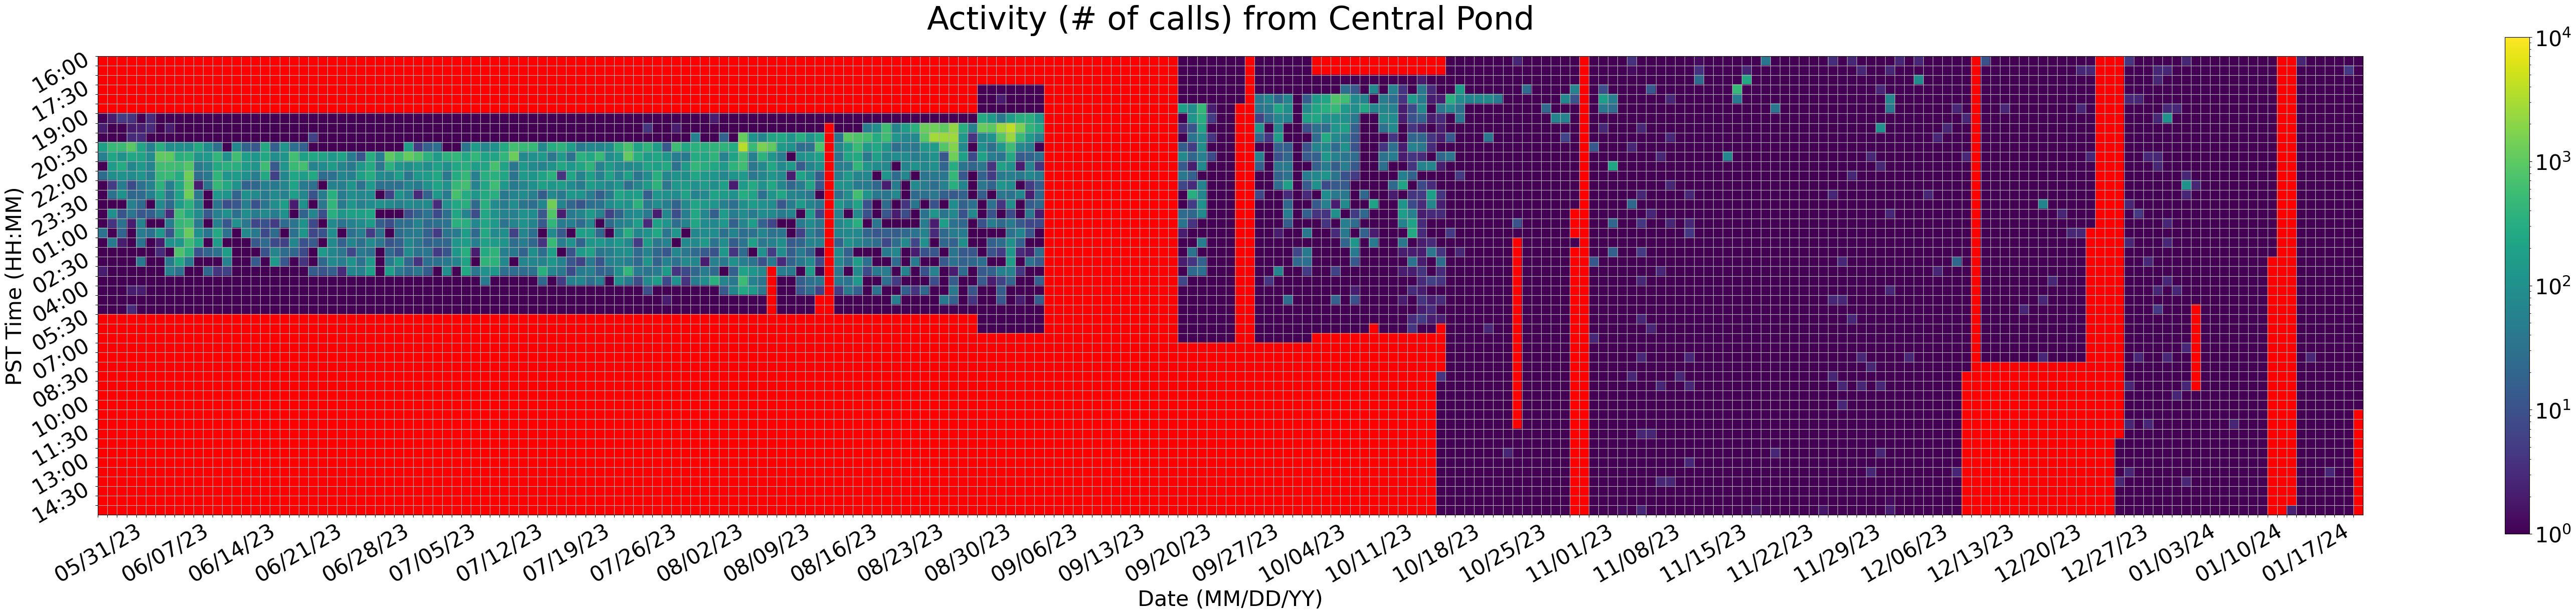

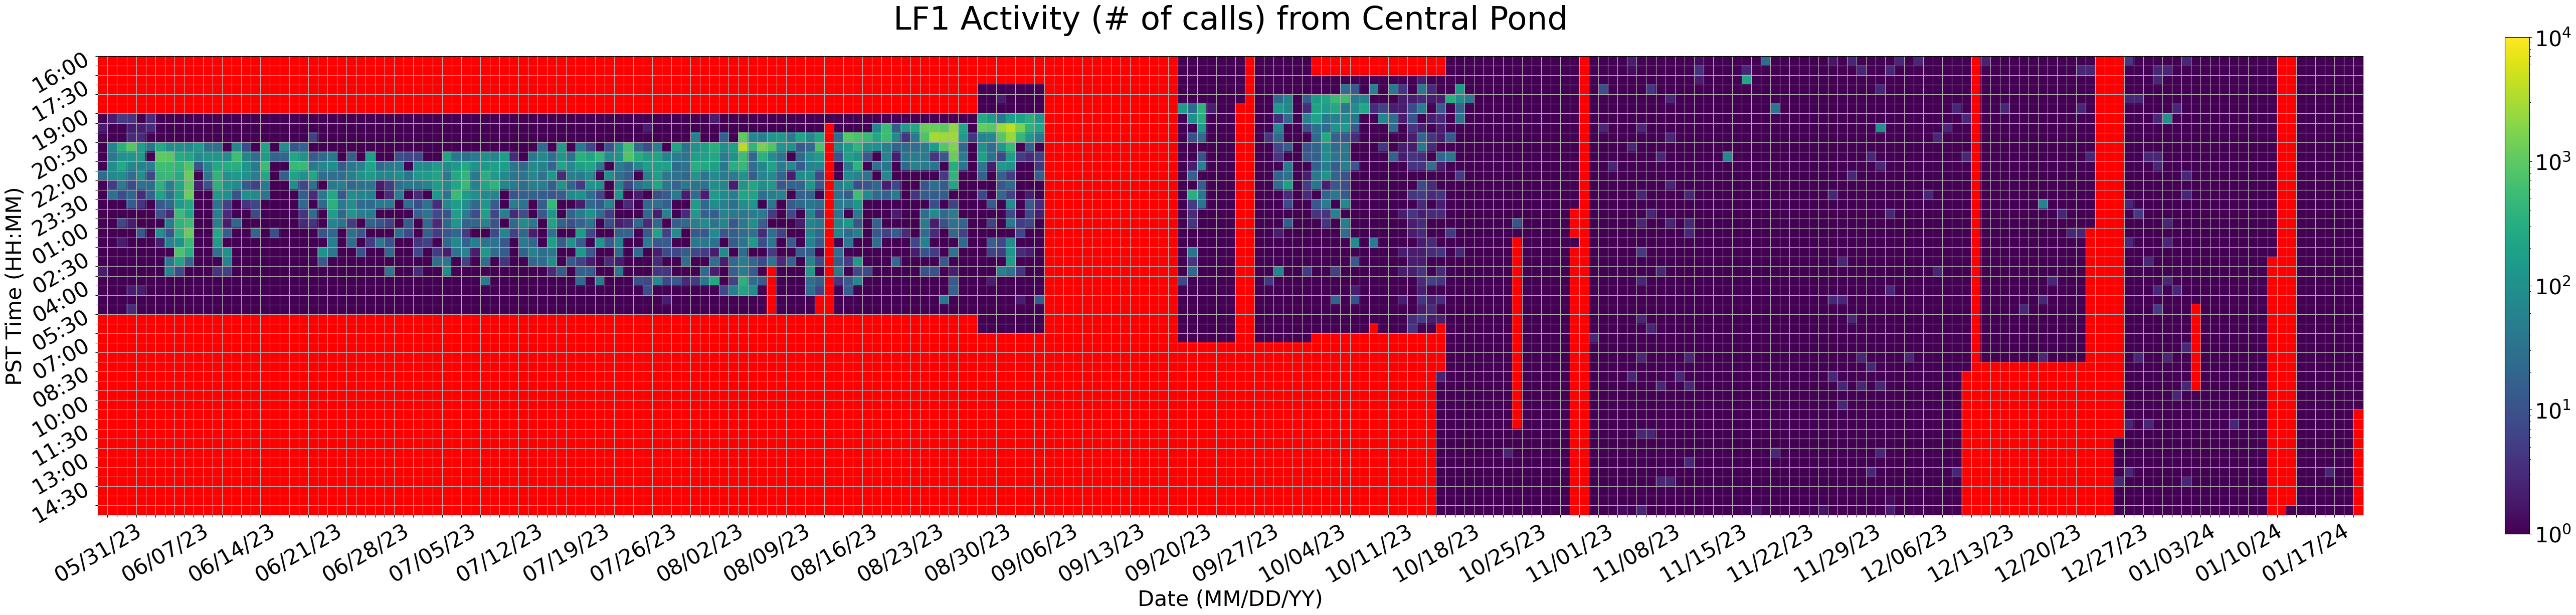

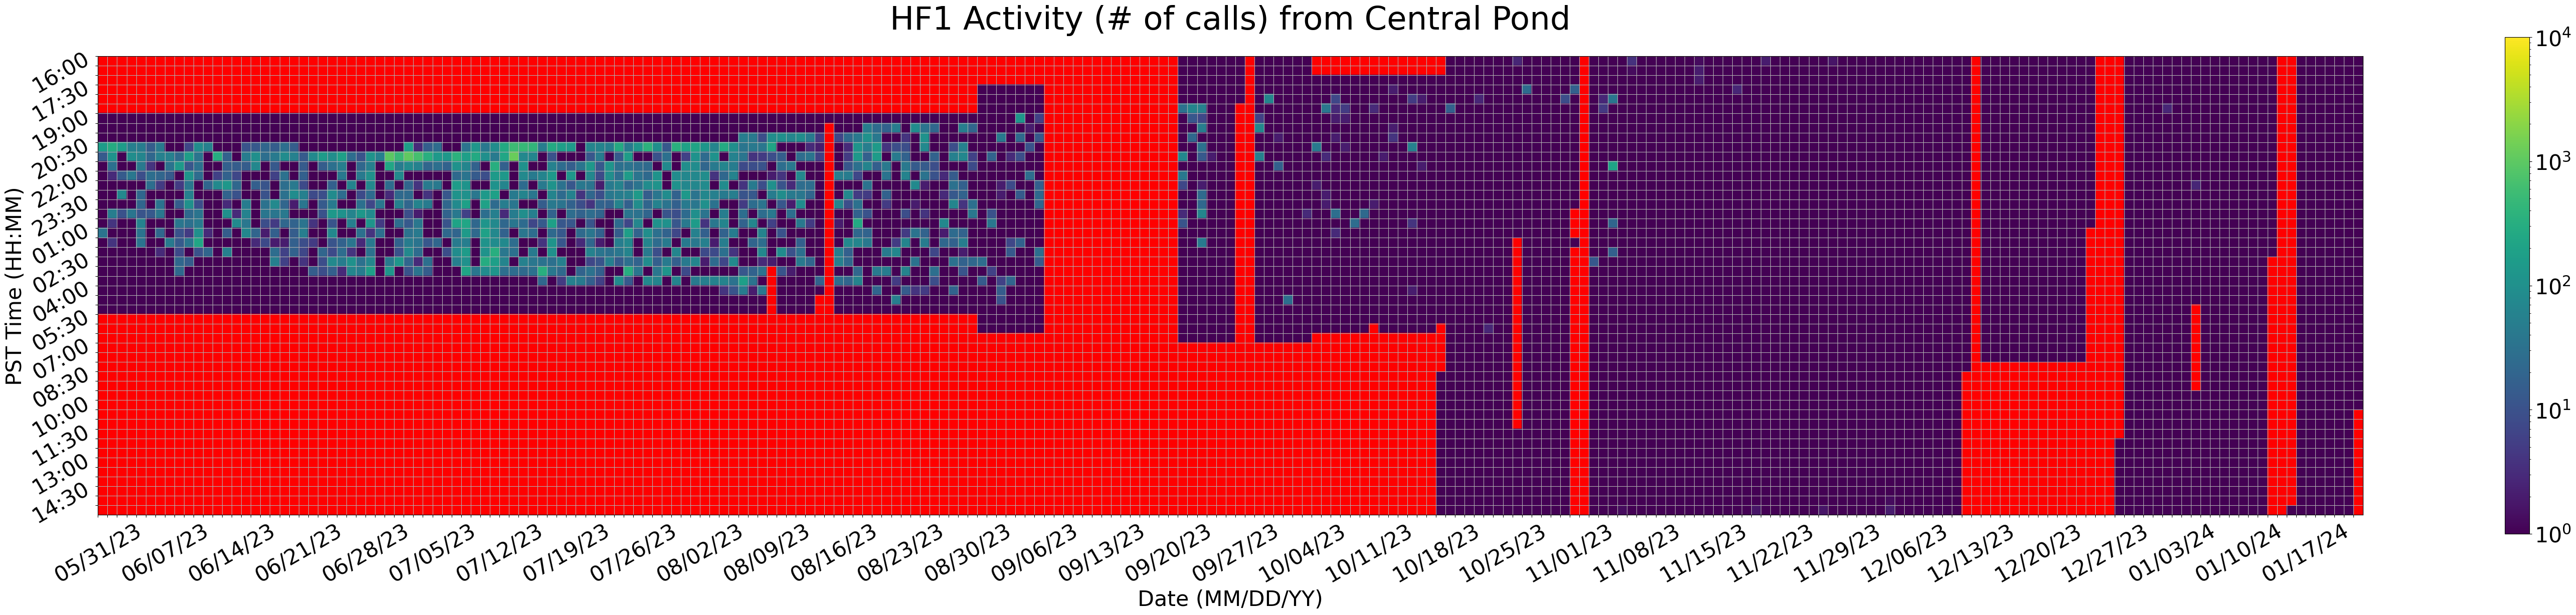

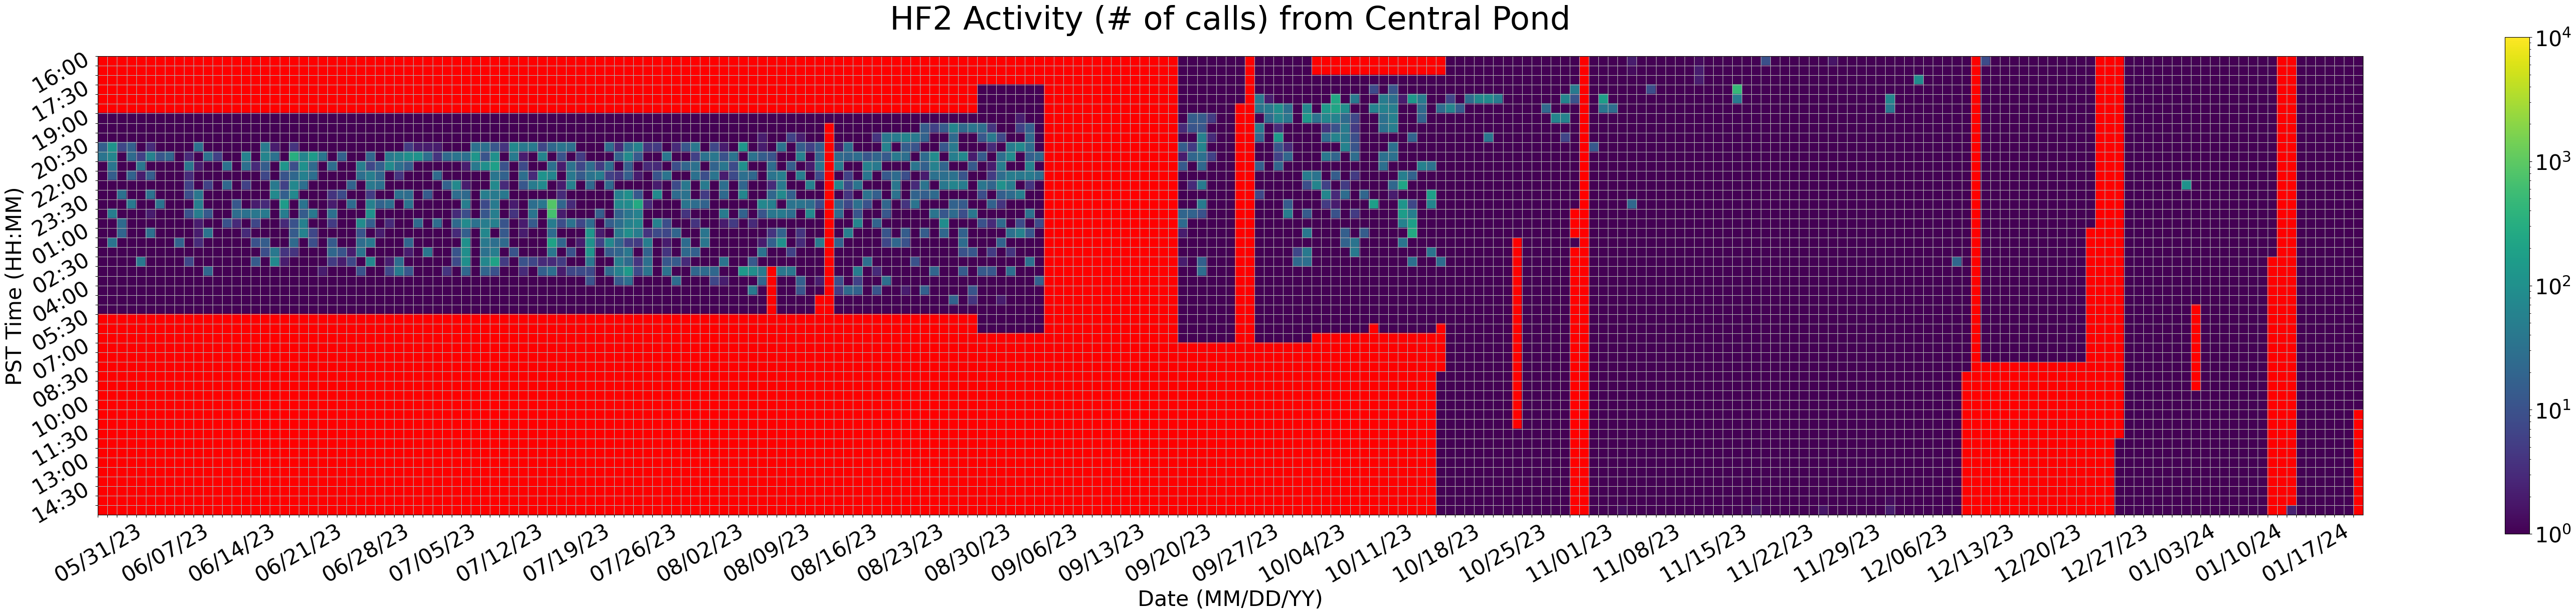

In [ ]:
site = "Central Pond"
cfg = dict()
cfg["site"] = site
cfg["recording_start"] = '00:00'
cfg["recording_end"] = '23:59'
cfg['resample_tag'] = "30T"
cfg['show_PST'] = True

for group in batdetect2_pipeline.FREQ_GROUPS[cfg["site"]].keys():
    activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, group)
    batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, group)

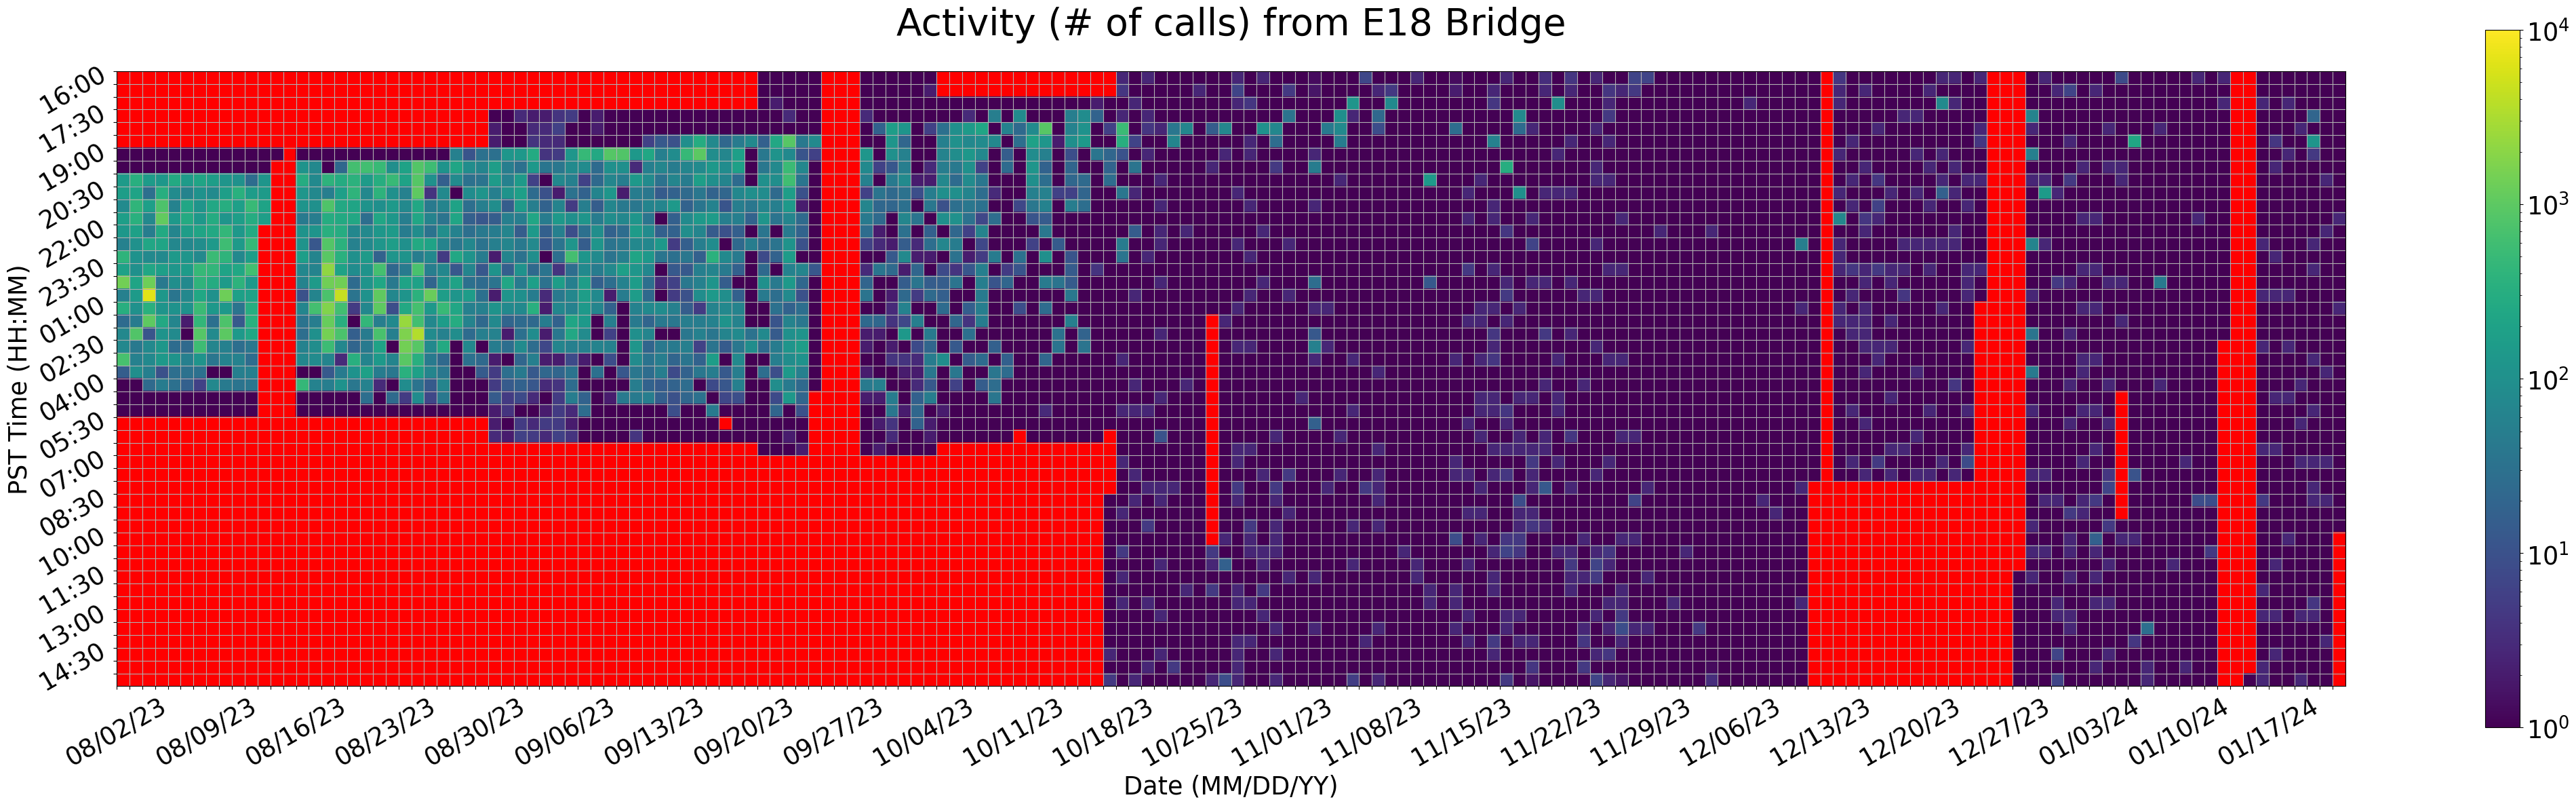

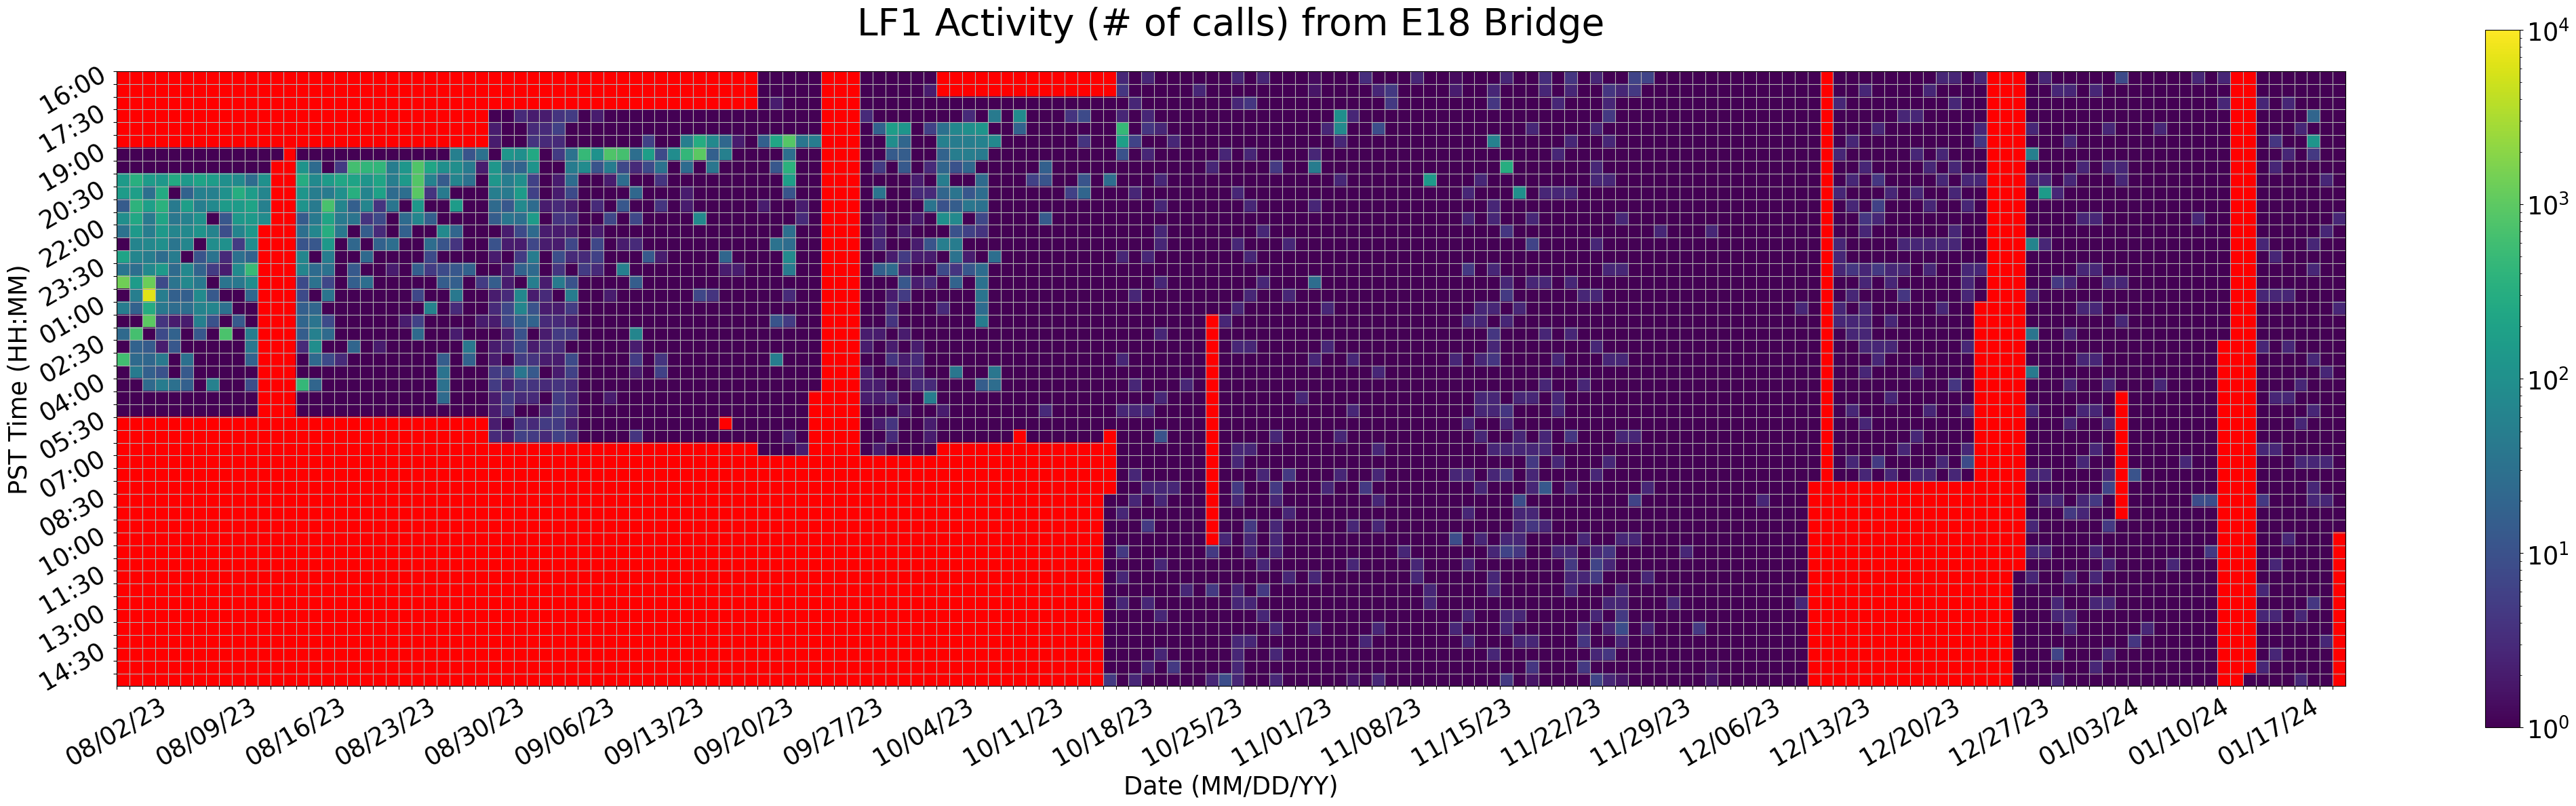

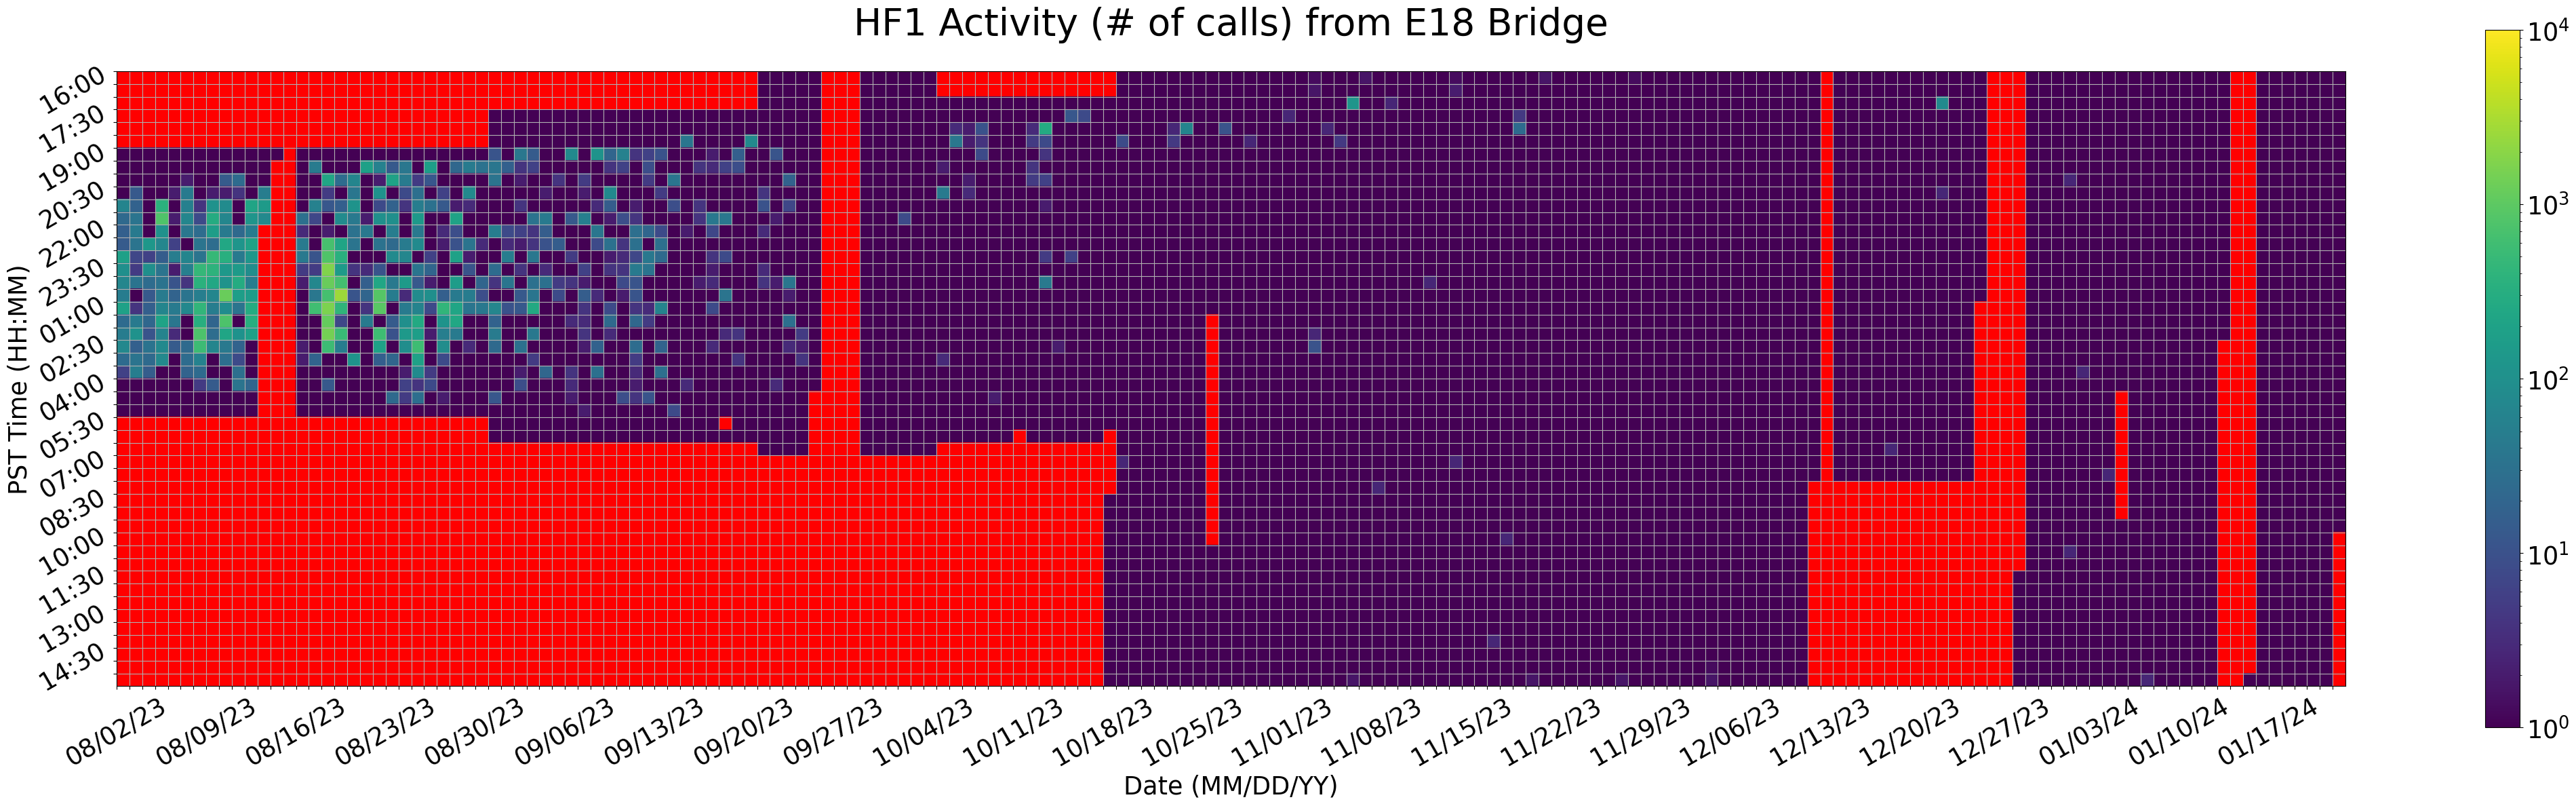

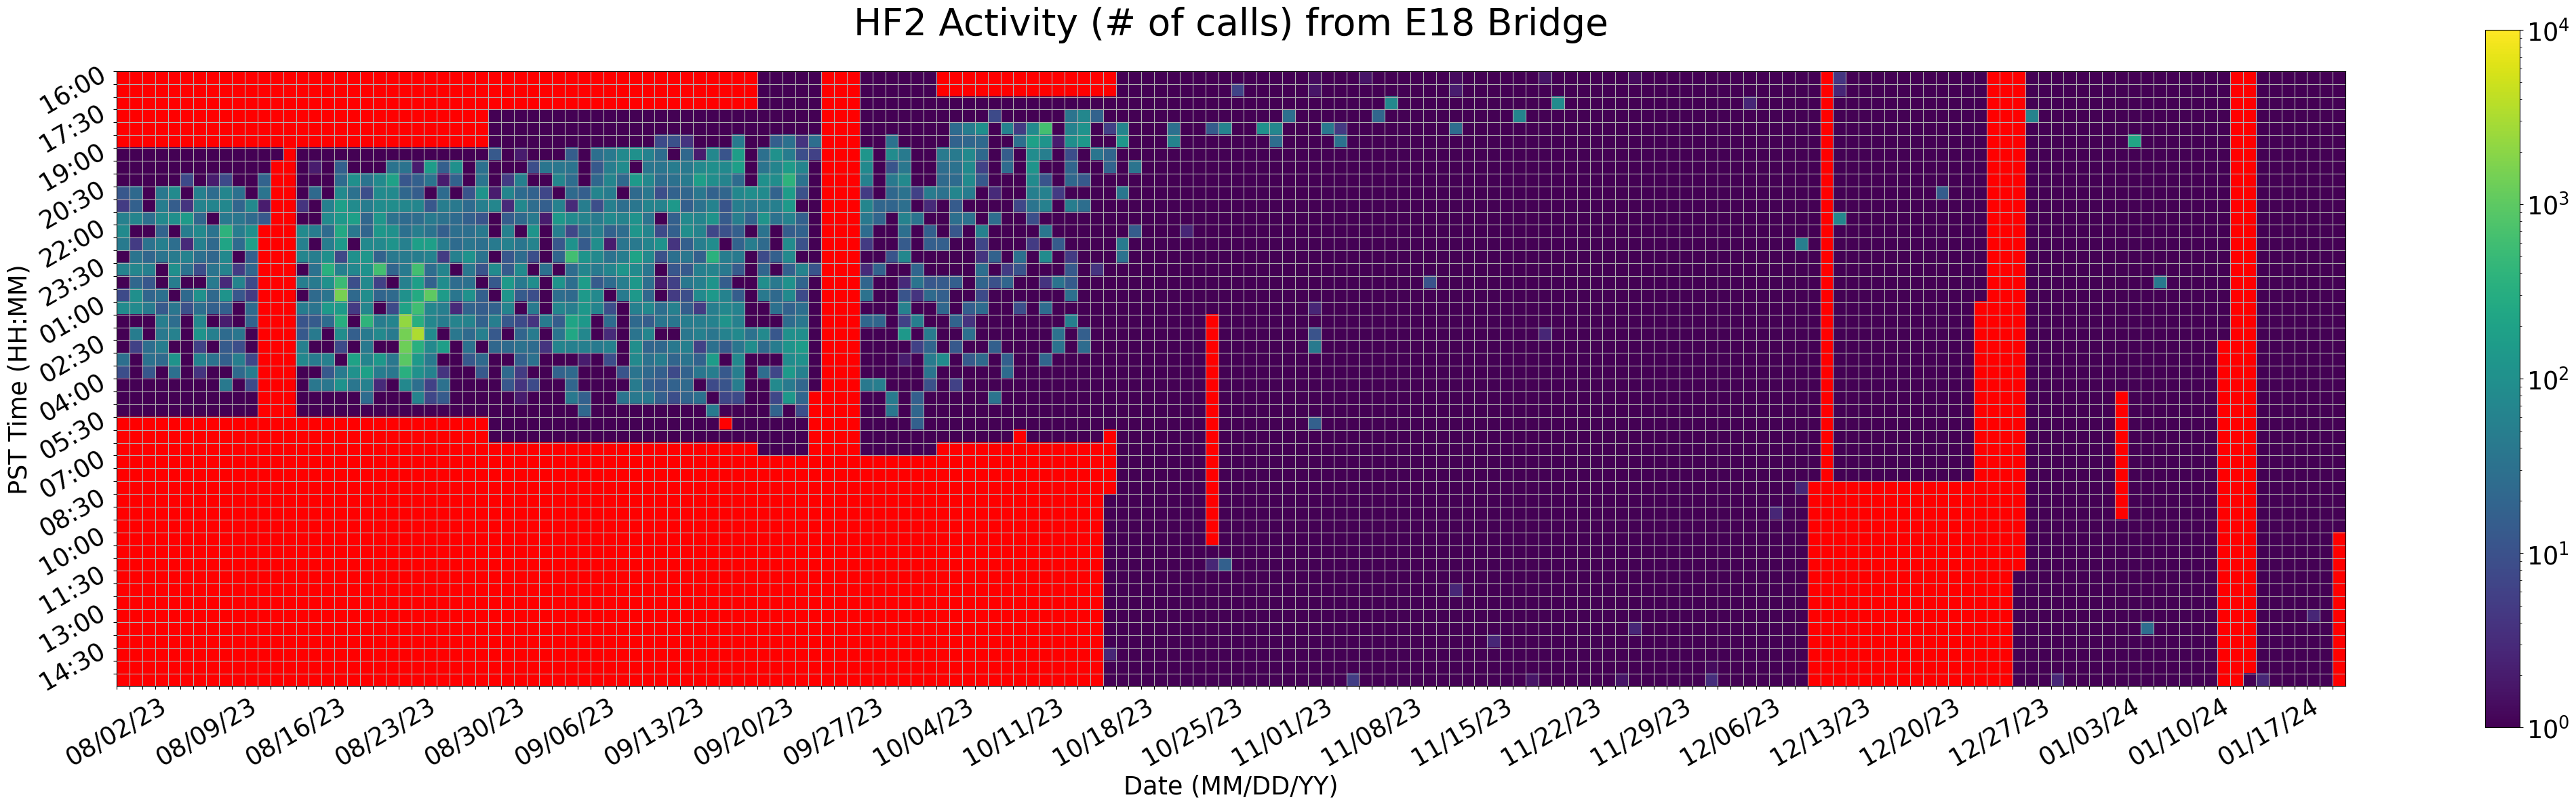

In [ ]:
site = "E18 Bridge"
cfg = dict()
cfg["site"] = site
cfg["recording_start"] = '00:00'
cfg["recording_end"] = '23:59'
cfg['resample_tag'] = "30T"
cfg['show_PST'] = True

for group in batdetect2_pipeline.FREQ_GROUPS[cfg["site"]].keys():
    activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg, cfg, group)
    batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg, group)

### c) The below code generates a plot for a single deployment session given the deployment detection file path

Searching for files from recover-20230927 and UBNA_009
Will save csv file to ../output_dir/recover-20230927/Central Pond
All files from deployment session good!


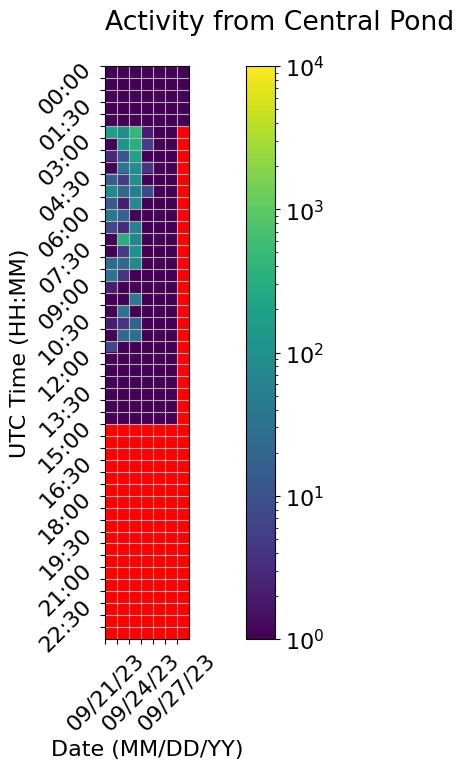

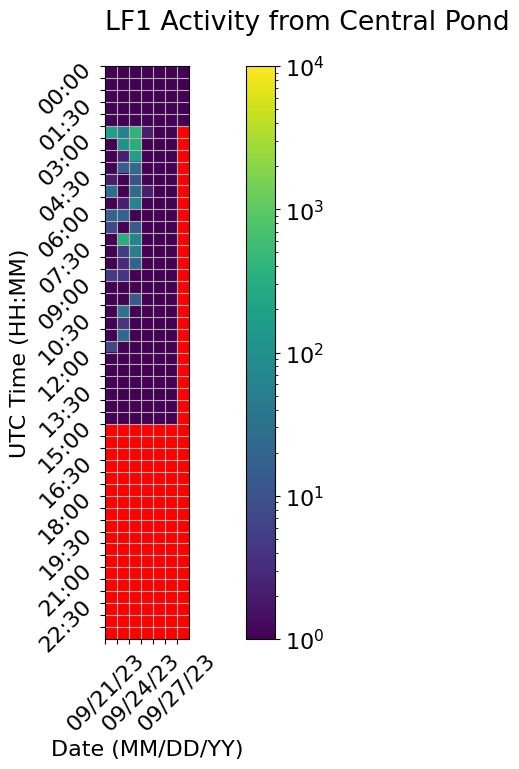

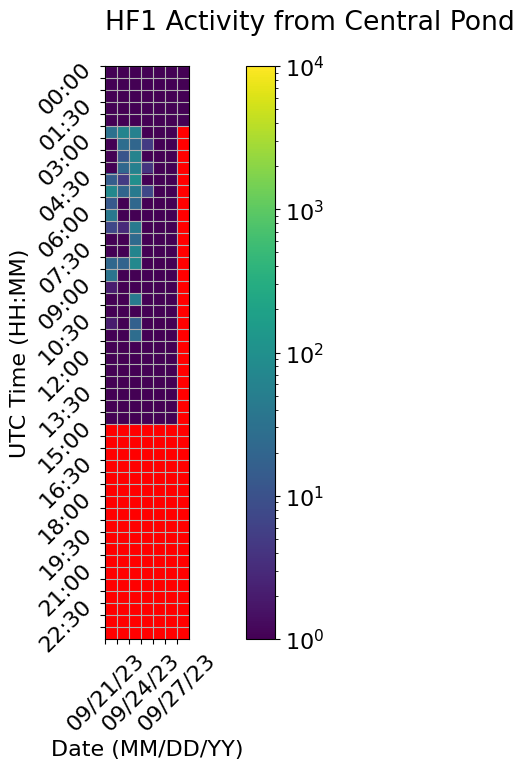

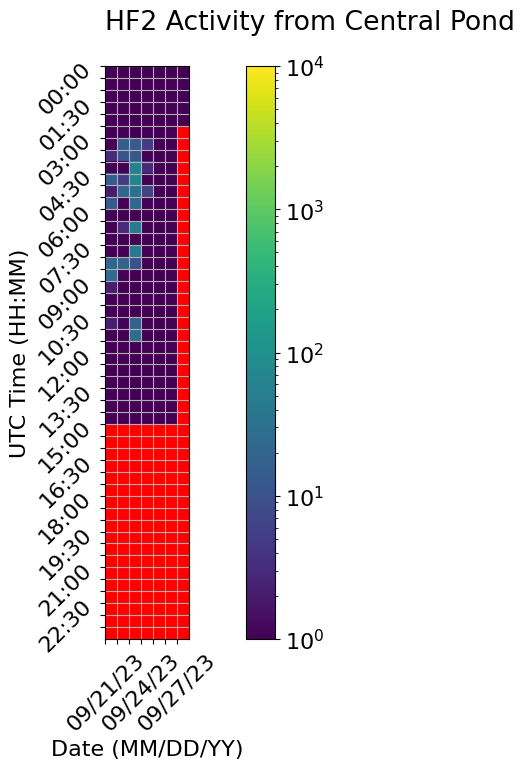

In [ ]:
sites = ['E18 Bridge', 'Central Pond', 'Foliage', 'Telephone Field']

cfg = dict()
cfg['recover_folder'] = 'recover-20230927'
cfg['sd_unit'] = '009'
cfg['site'] = 'Central Pond'
cfg['output_dir'] = Path(f"../output_dir/{cfg['recover_folder']}")
cfg['cycle_length'] = 1800
cfg['duration'] = 1800
cfg["recording_start"] = '00:00'
cfg["recording_end"] = '23:59'

data_params = batdetect2_pipeline.get_params_relevant_to_data(cfg)
cfg["csv_filename"] = f"bd2__{data_params['recover_folder']}_{data_params['audiomoth_folder']}"

data_params['resample_in_min'] = 30
data_params['resample_tag'] = f"{data_params['resample_in_min']}T"

batdetect2_pipeline.construct_activity_arr(cfg, data_params)
for group in batdetect2_pipeline.FREQ_GROUPS[cfg['site']].keys():
    activity_df = batdetect2_pipeline.shape_activity_array_into_grid(cfg, data_params, group)
    batdetect2_pipeline.plot_activity_grid(activity_df, data_params, group)

### d) The below code was written to loop for all deployment sessions to have a single uniform format between deployment sessions. The `bd2__` detection files remain untouched.

In [ ]:
def get_params_relevant_to_data_ubna_data_03(cfg):
    data_params = dict()
    data_params['recover_folder'] = cfg['recover_folder']
    data_params["audiomoth_folder"] = f"UBNA_{cfg['sd_unit']}"
    print(f"Searching for files from {cfg['recover_folder']} and {data_params['audiomoth_folder']}")

    cur_data_records = dd.read_csv(f'../output_dir/ubna_data_03_collected_audio_records.csv', dtype=str).compute()
    if 'Unnamed: 0' in cur_data_records.columns:
        cur_data_records.drop(columns='Unnamed: 0', inplace=True)
    print(cur_data_records.columns)
    cur_data_records["datetime_UTC"] = pd.DatetimeIndex(cur_data_records["datetime_UTC"])
    cur_data_records.set_index("datetime_UTC", inplace=True) 
    
    files_from_deployment_session = filter_df_with_deployment_session_ubna_data_03(cur_data_records, data_params['recover_folder'], cfg)
    site_name = files_from_deployment_session["site_name"].values[0]
    data_params["site"] = site_name
    if data_params["site"] != "(Site not found in Field Records)":
        data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
    elif cfg['site']!='none':
        data_params['output_dir'] = cfg["output_dir"] / cfg['site']
        data_params['site'] = cfg['site']
    else:
        data_params['output_dir'] = cfg["output_dir"] / f"UBNA_{cfg['sd_unit']}"
    print(f"Will save csv file to {data_params['output_dir']}")

    data_params['ref_audio_files'] = sorted(list(files_from_deployment_session["file_path"].apply(lambda x : Path(x)).values))
    file_status_cond = files_from_deployment_session["file_status"] == "Usable for detection"
    file_duration_cond = files_from_deployment_session["file_duration"].astype('float') >= (cfg['cycle_length'])/2
    good_deploy_session_df = files_from_deployment_session.loc[file_status_cond & file_duration_cond]
    data_params['good_audio_files'] = sorted(list(good_deploy_session_df["file_path"].apply(lambda x : Path(x)).values))

    if data_params['good_audio_files'] == data_params['ref_audio_files']:
        print("All files from deployment session good!")
    else:
        print("Error files exist!")

    return data_params

def filter_df_with_deployment_session_ubna_data_03(ubna_data_df, recover_folder, cfg):
    recover_folder_cond = ubna_data_df["recover_folder"] == recover_folder
    sd_unit_cond = ubna_data_df["sd_card_num"] == cfg["sd_unit"]
    filtered_location_df = ubna_data_df.loc[recover_folder_cond&sd_unit_cond].sort_index()

    start_time, end_time = batdetect2_pipeline.get_recording_period(Path(filtered_location_df['file_path'].values[0]).parent)
    file_minutes = pd.to_datetime(filtered_location_df.index.minute, format="%M")
    offset_from_config = dt.timedelta(minutes=dt.datetime.strptime(start_time, "%H:%M").minute)
    corrected_minutes = (file_minutes - offset_from_config).minute
    # datetime_cond = np.logical_and(np.mod(corrected_minutes, (cfg['cycle_length']/60)) == 0, filtered_location_df.index.second == 0)
    datetime_cond = filtered_location_df.index.second == 0
    file_error_cond = np.logical_and((filtered_location_df["file_duration"]!='File has no comment due to error!'), (filtered_location_df["file_duration"]!='File has no Audiomoth-related comment'))
    all_errors_cond = np.logical_and((filtered_location_df["file_duration"]!='Is empty!'), file_error_cond)
    filtered_location_df = filtered_location_df.loc[datetime_cond&all_errors_cond].sort_index()
    filtered_location_nightly_df = filtered_location_df.between_time(cfg['recording_start'], cfg['recording_end'], inclusive="left")

    return filtered_location_nightly_df

In [ ]:
def get_params_relevant_to_data_ubna_data_02(cfg):
    data_params = dict()
    data_params['recover_folder'] = cfg['recover_folder']
    data_params["audiomoth_folder"] = f"UBNA_{cfg['sd_unit']}"
    print(f"Searching for files from {cfg['recover_folder']} and {data_params['audiomoth_folder']}")

    cur_data_records = dd.read_csv(f'../output_dir/ubna_data_02_collected_audio_records.csv', dtype=str).compute()
    if 'Unnamed: 0' in cur_data_records.columns:
        cur_data_records.drop(columns='Unnamed: 0', inplace=True)
    print(cur_data_records.columns)
    cur_data_records["datetime_UTC"] = pd.DatetimeIndex(cur_data_records["Datetime UTC"])
    cur_data_records.set_index("datetime_UTC", inplace=True) 
    
    files_from_deployment_session = filter_df_with_deployment_session_ubna_data_02(cur_data_records, data_params['recover_folder'], cfg)
    site_name = files_from_deployment_session["Site name"].values[0]
    data_params["site"] = site_name
    if data_params["site"] != "(Site not found in Field Records)":
        data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
    elif cfg['site']!='none':
        data_params['output_dir'] = cfg["output_dir"] / cfg['site']
        data_params['site'] = cfg['site']
    else:
        data_params['output_dir'] = cfg["output_dir"] / f"UBNA_{cfg['sd_unit']}"
    print(f"Will save csv file to {data_params['output_dir']}")

    data_params['ref_audio_files'] = sorted(list(files_from_deployment_session["File path"].apply(lambda x : Path(x)).values))
    file_status_cond = files_from_deployment_session["File status"] == "Usable for detection"
    file_duration_cond = files_from_deployment_session["File duration"].astype('float') >= (cfg['cycle_length'])/2
    good_deploy_session_df = files_from_deployment_session.loc[file_status_cond & file_duration_cond]
    data_params['good_audio_files'] = sorted(list(good_deploy_session_df["File path"].apply(lambda x : Path(x)).values))

    if data_params['good_audio_files'] == data_params['ref_audio_files']:
        print("All files from deployment session good!")
    else:
        print("Error files exist!")

    return data_params

def filter_df_with_deployment_session_ubna_data_02(ubna_data_df, recover_folder, cfg):
    recover_folder_cond = ubna_data_df["Recover folder"] == recover_folder
    sd_unit_cond = ubna_data_df["SD card #"] == cfg["sd_unit"]
    filtered_location_df = ubna_data_df.loc[recover_folder_cond&sd_unit_cond].sort_index()

    start_time, end_time = batdetect2_pipeline.get_recording_period(Path(filtered_location_df['File path'].values[0]).parent)
    file_minutes = pd.to_datetime(filtered_location_df.index.minute, format="%M")
    offset_from_config = dt.timedelta(minutes=dt.datetime.strptime(start_time, "%H:%M").minute)
    corrected_minutes = (file_minutes - offset_from_config).minute
    datetime_cond = np.logical_and(np.mod(corrected_minutes, (cfg['cycle_length']/60)) == 0, filtered_location_df.index.second == 0)
    # datetime_cond = filtered_location_df.index.second == 0
    file_error_cond = np.logical_and((filtered_location_df["File duration"]!='File has no comment due to error!'), (filtered_location_df["File duration"]!='File has no Audiomoth-related comment'))
    all_errors_cond = np.logical_and((filtered_location_df["File duration"]!='Is empty!'), file_error_cond)
    filtered_location_df = filtered_location_df.loc[datetime_cond&all_errors_cond].sort_index()
    filtered_location_nightly_df = filtered_location_df.between_time(cfg['recording_start'], cfg['recording_end'], inclusive="left")

    return filtered_location_nightly_df

In [ ]:
recover_dates = sorted(list(Path('../output_dir').glob(pattern='recover-202[3|4]0115*')))
sites = ['E18 Bridge', 'Central Pond', 'Foliage', 'Telephone Field']
sd_card_pattern = re.compile(r'UBNA_0[0-9][0-9]')

for dir in recover_dates:

    cfg = dict()
    cfg['recover_folder'] = dir.name
    cfg['output_dir'] = Path(f"../output_dir/{cfg['recover_folder']}")
    cfg['cycle_length'] = 600
    cfg['duration'] = 300
    cfg["recording_start"] = '00:00'
    cfg["recording_end"] = '23:59'

    for site in sites:
        cfg['site'] = site
        print(Path(cfg['output_dir'] / site))
        print(Path(cfg['output_dir'] / site).is_dir())
        if Path(cfg['output_dir'] / site).is_dir():
            cfg['sd_unit'] = sd_card_pattern.search(list((Path(cfg['output_dir'] / site)).glob(pattern='*'))[0].name).group().split('_')[1]
            cfg["csv_filename"] = f"bd2__{cfg['recover_folder']}_UBNA_{cfg['sd_unit']}"
            print(cfg)

            data_params = get_params_relevant_to_data_ubna_data_03(cfg)
            data_params['resample_in_min'] = 30
            data_params['resample_tag'] = f"{data_params['resample_in_min']}T"
            print(data_params)

            batdetect2_pipeline.construct_activity_arr(cfg, data_params)

../output_dir/recover-20240115/E18 Bridge
True
{'recover_folder': 'recover-20240115', 'output_dir': PosixPath('../output_dir/recover-20240115'), 'cycle_length': 600, 'duration': 300, 'recording_start': '00:00', 'recording_end': '23:59', 'site': 'E18 Bridge', 'sd_unit': '017', 'csv_filename': 'bd2__recover-20240115_UBNA_017'}
Searching for files from recover-20240115 and UBNA_017
Index(['datetime_UTC', 'site_name', 'recover_folder', 'audiomoth_num',
       'sd_card_num', 'file_path', 'file_metadata', 'file_status',
       'audiomoth_temperature', 'audiomoth_battery', 'sample_rate',
       'audiomoth_artist_ID', 'file_duration', 'Deployment notes'],
      dtype='object')
Will save csv file to ../output_dir/recover-20240115/E18 Bridge
All files from deployment session good!
{'recover_folder': 'recover-20240115', 'audiomoth_folder': 'UBNA_017', 'site': 'E18 Bridge', 'output_dir': PosixPath('../output_dir/recover-20240115/E18 Bridge'), 'ref_audio_files': [PosixPath('/mnt/ubna_data_03/recove